Fix possible bug in the encoder-decoder reshaping, check results on different test cases (where validation runs and test runs are in interpolation as well as extrapolation regime)

Future:
- Check extrapolation (Higher BStrength compared to training)

- Loss function

- LR scheduler

- Latent space visualization

In [1]:
import os
import sys
import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt

import time
import datetime
import argparse
import numpy as np
import pandas as pd
from random import SystemRandom
import logging

import torch
import torch.nn as nn
from torch.nn.functional import relu
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

from rich.progress import track
import tqdm

adjoint=True
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

from sunpy.visualization import colormaps as cm    

import torchvision
import torchvision.transforms as T

import node_utils as nut
import data_utils as dut

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)

In [4]:
device = torch.device("cpu")
device

device(type='cpu')

In [5]:
args = {
    "niters": 1000,
    "lr": 1e-2,
    "save": "experiments/",
    "load": None,
    "r": 1991,
    "node-layers": 2,
    "mlp-layers": 1,
    "latents": 8,
    "units": 50,
    "test_mode": "t4p1",
    "resize_dims": (32, 128),
    "param_scaling": [50, 1]
    # "test_mode" can take values "t2p1, t4p1" for now (number of training vs val and test sims)
}

args

{'niters': 1000,
 'lr': 0.01,
 'save': 'experiments/',
 'load': None,
 'r': 1991,
 'node-layers': 2,
 'mlp-layers': 1,
 'latents': 8,
 'units': 50,
 'test_mode': 't4p1',
 'resize_dims': (32, 128),
 'param_scaling': [50, 1]}

In [6]:
validation_dir = "./validation_data"
validation_file = os.path.join(validation_dir, "CR2161_validation_PolarTensor.npy")
sim_file = os.path.join(validation_dir, "CR2161_SimID4edge_validation.npy")
param_file = os.path.join(validation_dir, "params_2161_validation.txt")

In [7]:
data_obj = dut.parse_datasets(validation_file, sim_file, param_file, args, device)

In [8]:
data_obj

{'train_dataloader': <generator object inf_generator at 0x7f28f6418190>,
 'val_dataloader': <generator object inf_generator at 0x7f28f6418200>,
 'test_dataloader': <generator object inf_generator at 0x7f28f6418270>,
 'train_params': array([[0.290078, 1.      ],
        [0.32116 , 1.      ],
        [0.38332 , 1.      ],
        [0.4144  , 1.      ]]),
 'val_params': array([[0.35224, 1.     ]]),
 'test_params': array([[0.196838, 1.      ]]),
 'train_dataset': [(tensor([[[0.1188, 0.1018, 0.1006,  ..., 0.1308, 0.2901, 1.0000],
            [0.1170, 0.0997, 0.0984,  ..., 0.1311, 0.2901, 1.0000],
            [0.1151, 0.0977, 0.0963,  ..., 0.1313, 0.2901, 1.0000],
            ...,
            [0.0726, 0.0463, 0.0399,  ..., 0.1419, 0.2901, 1.0000],
            [0.0726, 0.0460, 0.0392,  ..., 0.1421, 0.2901, 1.0000],
            [0.0727, 0.0457, 0.0386,  ..., 0.1420, 0.2901, 1.0000]]]),
   tensor([0.0000, 0.0233, 0.0465, 0.0698, 0.0930, 0.1163, 0.1395, 0.1628, 0.1860,
           0.2093, 0.2326, 

In [9]:
model = nut.PNODE_Conv(input_dim=4096, latent_dim=args["latents"], param_dim=2, 
                       device=device,
                      n_layers=args["node-layers"],
                      n_units=args["units"]).to(device)


pEncoder = nut.count_parameters(model.encoder)
pPNODE = nut.count_parameters(model.pnode)
pDecoder = nut.count_parameters(model.decoder_mlp) + nut.count_parameters(model.decoder_conv)

print(pEncoder + pPNODE + pDecoder)

nut.makedirs(os.path.join(os.getcwd(), "logs"))
logdir = os.path.join(os.getcwd(), "logs")

nut.makedirs(args["save"])
# nut.makedirs("./model_stopping")


if args["load"] is not None:
    experimentID = args["load"]
    print("Loading experiment")
else:
    experimentID = int(SystemRandom().random()*100000)
    print("Starting new experiment")
print(experimentID)

ckpt_path = os.path.join(args["save"], "experiment_" + str(experimentID) + '.ckpt')
print(ckpt_path)

logger = dut.get_logger(logpath=os.path.join(logdir, "expt_normalized_pnode_images_2.log"))
logger

logger.info(os.getcwd())
logger.info(model)
logger.info("Number of parameters: {}".format(pEncoder + pPNODE + pDecoder))
logger.info(args)
logger.info("Checkpoint Path")
logger.info(ckpt_path)
logger.info("Input Dim: ")
logger.info(data_obj["input_dim"])
logger.info("Param Dim: ")
logger.info(2)
logger.info("Latent Dim: ")
logger.info(args["latents"])
logger.info(device)

/home/ajivani/WLROM_new/WhiteLight
PNODE_Conv(
  (encoder): Sequential(
    (0): ZeroPad2d((7, 8, 7, 8))
    (1): Conv2d(1, 4, kernel_size=(16, 16), stride=(2, 2))
    (2): ELU(alpha=1.0)
    (3): ZeroPad2d((3, 4, 3, 4))
    (4): Conv2d(4, 8, kernel_size=(8, 8), stride=(2, 2))
    (5): ELU(alpha=1.0)
    (6): ZeroPad2d((1, 2, 1, 2))
    (7): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2))
    (8): ELU(alpha=1.0)
    (9): ZeroPad2d((0, 1, 0, 1))
    (10): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
    (11): ELU(alpha=1.0)
    (12): ZeroPad2d((0, 0, 0, 0))
    (13): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
    (14): ELU(alpha=1.0)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=256, out_features=8, bias=True)
    (17): ELU(alpha=1.0)
  )
  (pnode): ODENet(
    (odenet): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ELU(alp

75637
Starting new experiment
24007
experiments/experiment_24007.ckpt


In [10]:
experimentID

24007

In [11]:
0.01 * 0.5

0.005

In [12]:
# Credit to Hongfan Chen for the stopping and LR scheduling pipeline.

if args["load"] is None:
    optimizer = optim.Adamax(model.parameters(), lr=args["lr"])
    val_loss_list = []
    train_loss_list = []
    n_iters_to_viz = 1
    num_batches = 1
    early_stopping = nut.EarlyStopping(patience=200,verbose=False,
                                  path=ckpt_path)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.4, patience=50)


    trainMax = data_obj["max_train"].item()
    trainMin = data_obj["min_train"].item()

    for itr in track(range(1, num_batches * (args["niters"] + 1)), description="Looping over Epochs..."):
        optimizer.zero_grad()
        batch_dict = dut.get_next_batch(data_obj["train_dataloader"], device=device)

        raw_pred = model(batch_dict["tp_to_predict"], batch_dict["observed_data"])
        model_pred = torch.permute(torch.squeeze(raw_pred), (1, 0, 2)) * (trainMax - trainMin) + trainMin
        target = batch_dict["data_to_predict"] * (trainMax - trainMin) + trainMin

        loss = nut.oden_loss(target, model_pred, loss='smooth_l1')
        loss.backward()
        optimizer.step()

        train_loss_list.append(loss.item())


        val_dict = dut.get_next_batch(data_obj["val_dataloader"], device=device)
        raw_val_pred = model(val_dict["tp_to_predict"], val_dict["observed_data"])
        val_pred = torch.permute(torch.squeeze(raw_val_pred, 2), (1, 0, 2)) * (trainMax - trainMin) + trainMin
        val_target = val_dict["data_to_predict"] * (trainMax - trainMin) + trainMin

        val_loss = nut.oden_loss(val_target, val_pred, loss='smooth_l1')

        val_loss_list.append(val_loss.item())

        message = 'Epoch {:04d}|Val loss|Loss {:.6e}|Train loss{:.6e}|LR {:.5f}|'.format(
                        itr//num_batches, 
                        val_loss.item(), 
                        loss.item(), 
                        optimizer.param_groups[0]["lr"])

        logger.info(message)

        scheduler.step(val_loss)
        early_stopping(val_loss, model)
        scheduler.step(val_loss)

        if early_stopping.early_stop:
            print('Early stopping')
            break
        
    

Output()

Epoch 0001|Val loss|Loss 1.552673e-02|Train loss1.213474e-02|LR 0.01000|
Epoch 0002|Val loss|Loss 4.543960e-02|Train loss1.542516e-02|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0003|Val loss|Loss 6.553014e-03|Train loss4.518373e-02|LR 0.01000|
Epoch 0004|Val loss|Loss 5.311768e-03|Train loss6.496233e-03|LR 0.01000|
Epoch 0005|Val loss|Loss 4.124320e-03|Train loss5.274763e-03|LR 0.01000|
Epoch 0006|Val loss|Loss 4.222353e-03|Train loss4.092203e-03|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0007|Val loss|Loss 3.952866e-03|Train loss4.189175e-03|LR 0.01000|
Epoch 0008|Val loss|Loss 3.557642e-03|Train loss3.933619e-03|LR 0.01000|
Epoch 0009|Val loss|Loss 3.674619e-03|Train loss3.549257e-03|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0010|Val loss|Loss 3.461482e-03|Train loss3.671314e-03|LR 0.01000|
Epoch 0011|Val loss|Loss 3.076747e-03|Train loss3.473187e-03|LR 0.01000|
Epoch 0012|Val loss|Loss 3.006197e-03|Train loss3.116801e-03|LR 0.01000|
Epoch 0013|Val loss|Loss 2.946984e-03|Train loss3.080021e-03|LR 0.01000|
Epoch 0014|Val loss|Loss 2.691603e-03|Train loss3.051475e-03|LR 0.01000|
Epoch 0015|Val loss|Loss 2.716532e-03|Train loss2.814272e-03|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0016|Val loss|Loss 2.769916e-03|Train loss2.847175e-03|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0017|Val loss|Loss 2.673535e-03|Train loss2.911841e-03|LR 0.01000|
Epoch 0018|Val loss|Loss 2.661226e-03|Train loss2.835050e-03|LR 0.01000|
Epoch 0019|Val loss|Loss 2.651714e-03|Train loss2.840507e-03|LR 0.01000|
Epoch 0020|Val loss|Loss 2.485947e-03|Train loss2.829020e-03|LR 0.01000|
Epoch 0021|Val loss|Loss 2.458773e-03|Train loss2.639149e-03|LR 0.01000|
Epoch 0022|Val loss|Loss 2.451461e-03|Train loss2.582166e-03|LR 0.01000|
Epoch 0023|Val loss|Loss 2.349821e-03|Train loss2.556243e-03|LR 0.01000|
Epoch 0024|Val loss|Loss 2.357455e-03|Train loss2.451454e-03|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0025|Val loss|Loss 2.323919e-03|Train loss2.458614e-03|LR 0.01000|
Epoch 0026|Val loss|Loss 2.269013e-03|Train loss2.410663e-03|LR 0.01000|
Epoch 0027|Val loss|Loss 2.284736e-03|Train loss2.330075e-03|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0028|Val loss|Loss 2.161716e-03|Train loss2.330531e-03|LR 0.01000|
Epoch 0029|Val loss|Loss 2.129361e-03|Train loss2.216988e-03|LR 0.01000|
Epoch 0030|Val loss|Loss 2.044457e-03|Train loss2.202699e-03|LR 0.01000|
Epoch 0031|Val loss|Loss 2.035428e-03|Train loss2.113876e-03|LR 0.01000|
Epoch 0032|Val loss|Loss 1.956805e-03|Train loss2.081737e-03|LR 0.01000|
Epoch 0033|Val loss|Loss 1.917785e-03|Train loss2.003103e-03|LR 0.01000|
Epoch 0034|Val loss|Loss 1.850705e-03|Train loss1.982541e-03|LR 0.01000|
Epoch 0035|Val loss|Loss 1.867455e-03|Train loss1.903391e-03|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0036|Val loss|Loss 1.771775e-03|Train loss1.892517e-03|LR 0.01000|
Epoch 0037|Val loss|Loss 1.760894e-03|Train loss1.806473e-03|LR 0.01000|
Epoch 0038|Val loss|Loss 1.775352e-03|Train loss1.791305e-03|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0039|Val loss|Loss 1.754198e-03|Train loss1.767460e-03|LR 0.01000|
Epoch 0040|Val loss|Loss 1.681967e-03|Train loss1.740528e-03|LR 0.01000|
Epoch 0041|Val loss|Loss 1.640950e-03|Train loss1.693452e-03|LR 0.01000|
Epoch 0042|Val loss|Loss 1.654137e-03|Train loss1.645396e-03|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0043|Val loss|Loss 1.627433e-03|Train loss1.627031e-03|LR 0.01000|
Epoch 0044|Val loss|Loss 1.576374e-03|Train loss1.602567e-03|LR 0.01000|
Epoch 0045|Val loss|Loss 1.556869e-03|Train loss1.578223e-03|LR 0.01000|
Epoch 0046|Val loss|Loss 1.556132e-03|Train loss1.569187e-03|LR 0.01000|
Epoch 0047|Val loss|Loss 1.552124e-03|Train loss1.567922e-03|LR 0.01000|
Epoch 0048|Val loss|Loss 1.525294e-03|Train loss1.568766e-03|LR 0.01000|
Epoch 0049|Val loss|Loss 1.518360e-03|Train loss1.549797e-03|LR 0.01000|
Epoch 0050|Val loss|Loss 1.513253e-03|Train loss1.543452e-03|LR 0.01000|
Epoch 0051|Val loss|Loss 1.512064e-03|Train loss1.530737e-03|LR 0.01000|
Epoch 0052|Val loss|Loss 1.490106e-03|Train loss1.524567e-03|LR 0.01000|
Epoch 0053|Val loss|Loss 1.470032e-03|Train loss1.506461e-03|LR 0.01000|
Epoch 0054|Val loss|Loss 1.461972e-03|Train loss1.493224e-03|LR 0.01000|
Epoch 0055|Val loss|Loss 1.457376e-03|Train loss1.486035e-03|LR 0.01000|
Epoch 0056|Val loss|Loss 1.449944e-03|Train loss1.4

Epoch 0156|Val loss|Loss 8.735387e-04|Train loss9.072887e-04|LR 0.01000|
Epoch 0157|Val loss|Loss 8.657539e-04|Train loss8.996988e-04|LR 0.01000|
Epoch 0158|Val loss|Loss 8.580125e-04|Train loss8.921222e-04|LR 0.01000|
Epoch 0159|Val loss|Loss 8.503047e-04|Train loss8.845684e-04|LR 0.01000|
Epoch 0160|Val loss|Loss 8.425966e-04|Train loss8.770466e-04|LR 0.01000|
Epoch 0161|Val loss|Loss 8.349004e-04|Train loss8.695651e-04|LR 0.01000|
Epoch 0162|Val loss|Loss 8.272356e-04|Train loss8.621285e-04|LR 0.01000|
Epoch 0163|Val loss|Loss 8.196426e-04|Train loss8.547399e-04|LR 0.01000|
Epoch 0164|Val loss|Loss 8.120954e-04|Train loss8.474006e-04|LR 0.01000|
Epoch 0165|Val loss|Loss 8.045860e-04|Train loss8.401116e-04|LR 0.01000|
Epoch 0166|Val loss|Loss 7.971486e-04|Train loss8.328724e-04|LR 0.01000|
Epoch 0167|Val loss|Loss 7.897473e-04|Train loss8.256830e-04|LR 0.01000|
Epoch 0168|Val loss|Loss 7.823747e-04|Train loss8.185443e-04|LR 0.01000|
Epoch 0169|Val loss|Loss 7.750277e-04|Train loss8.1

EarlyStopping counter: 1 out of 200

Epoch 0188|Val loss|Loss 6.927146e-04|Train loss7.058347e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0189|Val loss|Loss 7.033921e-04|Train loss7.324114e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0190|Val loss|Loss 6.817299e-04|Train loss7.442601e-04|LR 0.01000|


EarlyStopping counter: 4 out of 200

Epoch 0191|Val loss|Loss 6.375654e-04|Train loss7.215357e-04|LR 0.01000|
Epoch 0192|Val loss|Loss 6.651095e-04|Train loss6.759558e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0193|Val loss|Loss 6.819179e-04|Train loss7.028956e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0194|Val loss|Loss 6.265675e-04|Train loss7.208582e-04|LR 0.01000|
Epoch 0195|Val loss|Loss 6.444579e-04|Train loss6.658488e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0196|Val loss|Loss 6.613489e-04|Train loss6.822441e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0197|Val loss|Loss 6.113914e-04|Train loss7.007295e-04|LR 0.01000|
Epoch 0198|Val loss|Loss 6.373182e-04|Train loss6.511039e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0199|Val loss|Loss 6.386185e-04|Train loss6.750958e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0200|Val loss|Loss 5.990429e-04|Train loss6.793119e-04|LR 0.01000|
Epoch 0201|Val loss|Loss 6.362068e-04|Train loss6.388570e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0202|Val loss|Loss 6.114038e-04|Train loss6.727851e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0203|Val loss|Loss 5.936982e-04|Train loss6.537600e-04|LR 0.01000|
Epoch 0204|Val loss|Loss 6.265938e-04|Train loss6.342284e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0205|Val loss|Loss 5.830650e-04|Train loss6.594973e-04|LR 0.01000|
Epoch 0206|Val loss|Loss 5.890891e-04|Train loss6.246794e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0207|Val loss|Loss 5.918183e-04|Train loss6.324837e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0208|Val loss|Loss 5.737692e-04|Train loss6.267410e-04|LR 0.01000|
Epoch 0209|Val loss|Loss 5.782670e-04|Train loss6.109401e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0210|Val loss|Loss 5.636478e-04|Train loss6.213289e-04|LR 0.01000|
Epoch 0211|Val loss|Loss 5.765307e-04|Train loss6.023748e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0212|Val loss|Loss 5.590082e-04|Train loss6.111560e-04|LR 0.01000|
Epoch 0213|Val loss|Loss 5.555258e-04|Train loss6.006470e-04|LR 0.01000|
Epoch 0214|Val loss|Loss 5.630145e-04|Train loss5.967906e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0215|Val loss|Loss 5.467020e-04|Train loss5.977249e-04|LR 0.01000|
Epoch 0216|Val loss|Loss 5.474668e-04|Train loss5.858265e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0217|Val loss|Loss 5.431496e-04|Train loss5.898834e-04|LR 0.01000|
Epoch 0218|Val loss|Loss 5.437208e-04|Train loss5.802129e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0219|Val loss|Loss 5.346760e-04|Train loss5.802246e-04|LR 0.01000|
Epoch 0220|Val loss|Loss 5.314001e-04|Train loss5.767699e-04|LR 0.01000|
Epoch 0221|Val loss|Loss 5.365375e-04|Train loss5.708353e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0222|Val loss|Loss 5.237586e-04|Train loss5.715852e-04|LR 0.01000|
Epoch 0223|Val loss|Loss 5.219399e-04|Train loss5.644473e-04|LR 0.01000|
Epoch 0224|Val loss|Loss 5.241423e-04|Train loss5.633223e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0225|Val loss|Loss 5.171690e-04|Train loss5.600507e-04|LR 0.01000|
Epoch 0226|Val loss|Loss 5.132659e-04|Train loss5.554112e-04|LR 0.01000|
Epoch 0227|Val loss|Loss 5.125576e-04|Train loss5.544834e-04|LR 0.01000|
Epoch 0228|Val loss|Loss 5.103741e-04|Train loss5.499032e-04|LR 0.01000|
Epoch 0229|Val loss|Loss 5.048062e-04|Train loss5.473939e-04|LR 0.01000|
Epoch 0230|Val loss|Loss 5.030122e-04|Train loss5.453787e-04|LR 0.01000|
Epoch 0231|Val loss|Loss 5.028865e-04|Train loss5.410865e-04|LR 0.01000|
Epoch 0232|Val loss|Loss 4.966415e-04|Train loss5.393808e-04|LR 0.01000|
Epoch 0233|Val loss|Loss 4.945209e-04|Train loss5.366513e-04|LR 0.01000|
Epoch 0234|Val loss|Loss 4.952447e-04|Train loss5.329032e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0235|Val loss|Loss 4.890565e-04|Train loss5.314548e-04|LR 0.01000|
Epoch 0236|Val loss|Loss 4.870147e-04|Train loss5.283739e-04|LR 0.01000|
Epoch 0237|Val loss|Loss 4.878724e-04|Train loss5.251335e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0238|Val loss|Loss 4.818937e-04|Train loss5.236648e-04|LR 0.01000|
Epoch 0239|Val loss|Loss 4.798241e-04|Train loss5.205550e-04|LR 0.01000|
Epoch 0240|Val loss|Loss 4.805435e-04|Train loss5.176649e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0241|Val loss|Loss 4.752742e-04|Train loss5.160612e-04|LR 0.01000|
Epoch 0242|Val loss|Loss 4.731894e-04|Train loss5.131690e-04|LR 0.01000|
Epoch 0243|Val loss|Loss 4.731794e-04|Train loss5.104375e-04|LR 0.01000|
Epoch 0244|Val loss|Loss 4.687574e-04|Train loss5.086653e-04|LR 0.01000|
Epoch 0245|Val loss|Loss 4.670879e-04|Train loss5.061152e-04|LR 0.01000|
Epoch 0246|Val loss|Loss 4.661895e-04|Train loss5.034667e-04|LR 0.01000|
Epoch 0247|Val loss|Loss 4.624011e-04|Train loss5.014824e-04|LR 0.01000|
Epoch 0248|Val loss|Loss 4.611954e-04|Train loss4.992380e-04|LR 0.01000|
Epoch 0249|Val loss|Loss 4.594441e-04|Train loss4.967594e-04|LR 0.01000|
Epoch 0250|Val loss|Loss 4.562764e-04|Train loss4.945561e-04|LR 0.01000|
Epoch 0251|Val loss|Loss 4.553339e-04|Train loss4.924248e-04|LR 0.01000|
Epoch 0252|Val loss|Loss 4.529348e-04|Train loss4.902140e-04|LR 0.01000|
Epoch 0253|Val loss|Loss 4.502992e-04|Train loss4.879641e-04|LR 0.01000|
Epoch 0254|Val loss|Loss 4.491902e-04|Train loss4.8

EarlyStopping counter: 1 out of 200

Epoch 0285|Val loss|Loss 3.953991e-04|Train loss4.256117e-04|LR 0.01000|
Epoch 0286|Val loss|Loss 3.999803e-04|Train loss4.259289e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0287|Val loss|Loss 4.077668e-04|Train loss4.289991e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0288|Val loss|Loss 4.335796e-04|Train loss4.412961e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0289|Val loss|Loss 4.704405e-04|Train loss4.659963e-04|LR 0.01000|


EarlyStopping counter: 4 out of 200

Epoch 0290|Val loss|Loss 4.356368e-04|Train loss5.153529e-04|LR 0.01000|


EarlyStopping counter: 5 out of 200

Epoch 0291|Val loss|Loss 3.890750e-04|Train loss4.634405e-04|LR 0.01000|
Epoch 0292|Val loss|Loss 4.046338e-04|Train loss4.201280e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0293|Val loss|Loss 4.103537e-04|Train loss4.333708e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0294|Val loss|Loss 3.863770e-04|Train loss4.385173e-04|LR 0.01000|
Epoch 0295|Val loss|Loss 3.948711e-04|Train loss4.183545e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0296|Val loss|Loss 3.931167e-04|Train loss4.216328e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0297|Val loss|Loss 3.785517e-04|Train loss4.220265e-04|LR 0.01000|
Epoch 0298|Val loss|Loss 3.903961e-04|Train loss4.085169e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0299|Val loss|Loss 3.804250e-04|Train loss4.170532e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0300|Val loss|Loss 3.716238e-04|Train loss4.091281e-04|LR 0.01000|
Epoch 0301|Val loss|Loss 3.834112e-04|Train loss4.006996e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0302|Val loss|Loss 3.699784e-04|Train loss4.101204e-04|LR 0.01000|
Epoch 0303|Val loss|Loss 3.714327e-04|Train loss3.981522e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0304|Val loss|Loss 3.727250e-04|Train loss3.982681e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0305|Val loss|Loss 3.645224e-04|Train loss3.988828e-04|LR 0.01000|
Epoch 0306|Val loss|Loss 3.692748e-04|Train loss3.929877e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0307|Val loss|Loss 3.645309e-04|Train loss3.940894e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0308|Val loss|Loss 3.609718e-04|Train loss3.886395e-04|LR 0.01000|
Epoch 0309|Val loss|Loss 3.608789e-04|Train loss3.900065e-04|LR 0.01000|
Epoch 0310|Val loss|Loss 3.607151e-04|Train loss3.853262e-04|LR 0.01000|
Epoch 0311|Val loss|Loss 3.566916e-04|Train loss3.836769e-04|LR 0.01000|
Epoch 0312|Val loss|Loss 3.540391e-04|Train loss3.844531e-04|LR 0.01000|
Epoch 0313|Val loss|Loss 3.561837e-04|Train loss3.790953e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0314|Val loss|Loss 3.509260e-04|Train loss3.799977e-04|LR 0.01000|
Epoch 0315|Val loss|Loss 3.508070e-04|Train loss3.776451e-04|LR 0.01000|
Epoch 0316|Val loss|Loss 3.505943e-04|Train loss3.752899e-04|LR 0.01000|
Epoch 0317|Val loss|Loss 3.463910e-04|Train loss3.744747e-04|LR 0.01000|
Epoch 0318|Val loss|Loss 3.477500e-04|Train loss3.719875e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0319|Val loss|Loss 3.452418e-04|Train loss3.713136e-04|LR 0.01000|
Epoch 0320|Val loss|Loss 3.431950e-04|Train loss3.686507e-04|LR 0.01000|
Epoch 0321|Val loss|Loss 3.442953e-04|Train loss3.673933e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0322|Val loss|Loss 3.405150e-04|Train loss3.666154e-04|LR 0.01000|
Epoch 0323|Val loss|Loss 3.397885e-04|Train loss3.636404e-04|LR 0.01000|
Epoch 0324|Val loss|Loss 3.403055e-04|Train loss3.630802e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0325|Val loss|Loss 3.369451e-04|Train loss3.615786e-04|LR 0.01000|
Epoch 0326|Val loss|Loss 3.361500e-04|Train loss3.594217e-04|LR 0.01000|
Epoch 0327|Val loss|Loss 3.358354e-04|Train loss3.585865e-04|LR 0.01000|
Epoch 0328|Val loss|Loss 3.336437e-04|Train loss3.567679e-04|LR 0.01000|
Epoch 0329|Val loss|Loss 3.330250e-04|Train loss3.554483e-04|LR 0.01000|
Epoch 0330|Val loss|Loss 3.319308e-04|Train loss3.540451e-04|LR 0.01000|
Epoch 0331|Val loss|Loss 3.299536e-04|Train loss3.523812e-04|LR 0.01000|
Epoch 0332|Val loss|Loss 3.296940e-04|Train loss3.513737e-04|LR 0.01000|
Epoch 0333|Val loss|Loss 3.281294e-04|Train loss3.497548e-04|LR 0.01000|
Epoch 0334|Val loss|Loss 3.263074e-04|Train loss3.482199e-04|LR 0.01000|
Epoch 0335|Val loss|Loss 3.261599e-04|Train loss3.472414e-04|LR 0.01000|
Epoch 0336|Val loss|Loss 3.243810e-04|Train loss3.456899e-04|LR 0.01000|
Epoch 0337|Val loss|Loss 3.230893e-04|Train loss3.442420e-04|LR 0.01000|
Epoch 0338|Val loss|Loss 3.227844e-04|Train loss3.4

EarlyStopping counter: 1 out of 200

Epoch 0407|Val loss|Loss 2.631760e-04|Train loss2.734433e-04|LR 0.01000|
Epoch 0408|Val loss|Loss 2.656677e-04|Train loss2.729879e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0409|Val loss|Loss 2.631719e-04|Train loss2.729137e-04|LR 0.01000|
Epoch 0410|Val loss|Loss 2.713545e-04|Train loss2.737528e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0411|Val loss|Loss 2.716524e-04|Train loss2.764759e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0412|Val loss|Loss 2.992821e-04|Train loss2.840583e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0413|Val loss|Loss 3.109039e-04|Train loss2.993133e-04|LR 0.01000|


EarlyStopping counter: 4 out of 200

Epoch 0414|Val loss|Loss 3.291351e-04|Train loss3.262571e-04|LR 0.01000|


EarlyStopping counter: 5 out of 200

Epoch 0415|Val loss|Loss 2.814265e-04|Train loss3.244264e-04|LR 0.01000|


EarlyStopping counter: 6 out of 200

Epoch 0416|Val loss|Loss 2.609330e-04|Train loss2.959419e-04|LR 0.01000|
Epoch 0417|Val loss|Loss 2.811956e-04|Train loss2.672486e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0418|Val loss|Loss 2.818535e-04|Train loss2.818436e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0419|Val loss|Loss 2.692862e-04|Train loss2.961915e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0420|Val loss|Loss 2.636806e-04|Train loss2.724257e-04|LR 0.01000|


EarlyStopping counter: 4 out of 200

Epoch 0421|Val loss|Loss 2.697963e-04|Train loss2.682951e-04|LR 0.01000|


EarlyStopping counter: 5 out of 200

Epoch 0422|Val loss|Loss 2.670076e-04|Train loss2.826719e-04|LR 0.01000|


EarlyStopping counter: 6 out of 200

Epoch 0423|Val loss|Loss 2.588718e-04|Train loss2.702226e-04|LR 0.01000|
Epoch 0424|Val loss|Loss 2.610280e-04|Train loss2.645599e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0425|Val loss|Loss 2.617489e-04|Train loss2.735552e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0426|Val loss|Loss 2.563095e-04|Train loss2.663371e-04|LR 0.01000|
Epoch 0427|Val loss|Loss 2.559294e-04|Train loss2.620512e-04|LR 0.01000|
Epoch 0428|Val loss|Loss 2.569182e-04|Train loss2.674774e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0429|Val loss|Loss 2.525314e-04|Train loss2.628771e-04|LR 0.01000|
Epoch 0430|Val loss|Loss 2.522193e-04|Train loss2.590877e-04|LR 0.01000|
Epoch 0431|Val loss|Loss 2.533009e-04|Train loss2.631379e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0432|Val loss|Loss 2.494630e-04|Train loss2.595015e-04|LR 0.01000|
Epoch 0433|Val loss|Loss 2.493169e-04|Train loss2.562571e-04|LR 0.01000|
Epoch 0434|Val loss|Loss 2.494959e-04|Train loss2.597363e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0435|Val loss|Loss 2.473840e-04|Train loss2.560488e-04|LR 0.01000|
Epoch 0436|Val loss|Loss 2.475196e-04|Train loss2.538967e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0437|Val loss|Loss 2.471389e-04|Train loss2.565755e-04|LR 0.01000|
Epoch 0438|Val loss|Loss 2.457637e-04|Train loss2.530281e-04|LR 0.01000|
Epoch 0439|Val loss|Loss 2.451468e-04|Train loss2.519040e-04|LR 0.01000|
Epoch 0440|Val loss|Loss 2.450697e-04|Train loss2.534584e-04|LR 0.01000|
Epoch 0441|Val loss|Loss 2.440799e-04|Train loss2.505709e-04|LR 0.01000|
Epoch 0442|Val loss|Loss 2.428615e-04|Train loss2.499129e-04|LR 0.01000|
Epoch 0443|Val loss|Loss 2.433463e-04|Train loss2.505208e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0444|Val loss|Loss 2.421899e-04|Train loss2.484882e-04|LR 0.01000|
Epoch 0445|Val loss|Loss 2.407333e-04|Train loss2.477660e-04|LR 0.01000|
Epoch 0446|Val loss|Loss 2.417700e-04|Train loss2.478978e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0447|Val loss|Loss 2.401144e-04|Train loss2.465626e-04|LR 0.01000|
Epoch 0448|Val loss|Loss 2.388540e-04|Train loss2.455847e-04|LR 0.01000|
Epoch 0449|Val loss|Loss 2.403454e-04|Train loss2.455360e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0450|Val loss|Loss 2.381981e-04|Train loss2.446523e-04|LR 0.01000|
Epoch 0451|Val loss|Loss 2.370268e-04|Train loss2.434997e-04|LR 0.01000|
Epoch 0452|Val loss|Loss 2.386034e-04|Train loss2.433607e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0453|Val loss|Loss 2.364808e-04|Train loss2.427309e-04|LR 0.01000|
Epoch 0454|Val loss|Loss 2.355736e-04|Train loss2.415517e-04|LR 0.01000|
Epoch 0455|Val loss|Loss 2.368752e-04|Train loss2.412870e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0456|Val loss|Loss 2.347059e-04|Train loss2.408133e-04|LR 0.01000|
Epoch 0457|Val loss|Loss 2.340056e-04|Train loss2.397291e-04|LR 0.01000|
Epoch 0458|Val loss|Loss 2.350790e-04|Train loss2.392889e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0459|Val loss|Loss 2.330651e-04|Train loss2.388983e-04|LR 0.01000|
Epoch 0460|Val loss|Loss 2.325307e-04|Train loss2.379816e-04|LR 0.01000|
Epoch 0461|Val loss|Loss 2.331043e-04|Train loss2.373803e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0462|Val loss|Loss 2.313727e-04|Train loss2.369940e-04|LR 0.01000|
Epoch 0463|Val loss|Loss 2.311032e-04|Train loss2.362708e-04|LR 0.01000|
Epoch 0464|Val loss|Loss 2.311550e-04|Train loss2.355687e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0465|Val loss|Loss 2.297290e-04|Train loss2.351072e-04|LR 0.01000|
Epoch 0466|Val loss|Loss 2.297180e-04|Train loss2.345498e-04|LR 0.01000|
Epoch 0467|Val loss|Loss 2.293327e-04|Train loss2.338487e-04|LR 0.01000|
Epoch 0468|Val loss|Loss 2.282407e-04|Train loss2.332754e-04|LR 0.01000|
Epoch 0469|Val loss|Loss 2.283272e-04|Train loss2.327960e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0470|Val loss|Loss 2.275233e-04|Train loss2.321817e-04|LR 0.01000|
Epoch 0471|Val loss|Loss 2.267725e-04|Train loss2.315320e-04|LR 0.01000|
Epoch 0472|Val loss|Loss 2.268402e-04|Train loss2.310265e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0473|Val loss|Loss 2.258767e-04|Train loss2.305117e-04|LR 0.01000|
Epoch 0474|Val loss|Loss 2.254063e-04|Train loss2.298818e-04|LR 0.01000|
Epoch 0475|Val loss|Loss 2.253129e-04|Train loss2.293135e-04|LR 0.01000|
Epoch 0476|Val loss|Loss 2.244300e-04|Train loss2.288430e-04|LR 0.01000|
Epoch 0477|Val loss|Loss 2.242628e-04|Train loss2.283337e-04|LR 0.01000|
Epoch 0478|Val loss|Loss 2.238978e-04|Train loss2.278374e-04|LR 0.01000|
Epoch 0479|Val loss|Loss 2.236820e-04|Train loss2.275542e-04|LR 0.01000|
Epoch 0480|Val loss|Loss 2.246472e-04|Train loss2.276277e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0481|Val loss|Loss 2.267010e-04|Train loss2.285383e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0482|Val loss|Loss 2.337515e-04|Train loss2.314700e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0483|Val loss|Loss 2.488365e-04|Train loss2.405717e-04|LR 0.01000|


EarlyStopping counter: 4 out of 200

Epoch 0484|Val loss|Loss 2.840600e-04|Train loss2.593561e-04|LR 0.01000|


EarlyStopping counter: 5 out of 200

Epoch 0485|Val loss|Loss 2.818044e-04|Train loss3.045739e-04|LR 0.01000|


EarlyStopping counter: 6 out of 200

Epoch 0486|Val loss|Loss 2.547182e-04|Train loss3.015023e-04|LR 0.01000|


EarlyStopping counter: 7 out of 200

Epoch 0487|Val loss|Loss 2.219550e-04|Train loss2.679335e-04|LR 0.01000|
Epoch 0488|Val loss|Loss 2.469023e-04|Train loss2.247325e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0489|Val loss|Loss 2.557634e-04|Train loss2.537896e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0490|Val loss|Loss 2.217499e-04|Train loss2.703282e-04|LR 0.01000|
Epoch 0491|Val loss|Loss 2.447618e-04|Train loss2.248584e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0492|Val loss|Loss 2.467466e-04|Train loss2.511793e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0493|Val loss|Loss 2.201572e-04|Train loss2.558175e-04|LR 0.01000|
Epoch 0494|Val loss|Loss 2.521806e-04|Train loss2.239108e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0495|Val loss|Loss 2.295339e-04|Train loss2.594839e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0496|Val loss|Loss 2.284485e-04|Train loss2.376073e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0497|Val loss|Loss 2.400580e-04|Train loss2.339801e-04|LR 0.01000|


EarlyStopping counter: 4 out of 200

Epoch 0498|Val loss|Loss 2.173157e-04|Train loss2.462191e-04|LR 0.01000|
Epoch 0499|Val loss|Loss 2.349429e-04|Train loss2.229991e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0500|Val loss|Loss 2.179765e-04|Train loss2.406263e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0501|Val loss|Loss 2.240408e-04|Train loss2.214972e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0502|Val loss|Loss 2.226789e-04|Train loss2.301592e-04|LR 0.01000|


EarlyStopping counter: 4 out of 200

Epoch 0503|Val loss|Loss 2.180566e-04|Train loss2.264503e-04|LR 0.01000|


EarlyStopping counter: 5 out of 200

Epoch 0504|Val loss|Loss 2.214190e-04|Train loss2.215831e-04|LR 0.01000|


EarlyStopping counter: 6 out of 200

Epoch 0505|Val loss|Loss 2.165738e-04|Train loss2.262529e-04|LR 0.01000|
Epoch 0506|Val loss|Loss 2.189789e-04|Train loss2.178243e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0507|Val loss|Loss 2.128809e-04|Train loss2.236145e-04|LR 0.01000|
Epoch 0508|Val loss|Loss 2.200889e-04|Train loss2.160131e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0509|Val loss|Loss 2.120496e-04|Train loss2.215402e-04|LR 0.01000|
Epoch 0510|Val loss|Loss 2.138437e-04|Train loss2.157709e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0511|Val loss|Loss 2.144426e-04|Train loss2.172369e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0512|Val loss|Loss 2.115970e-04|Train loss2.158214e-04|LR 0.01000|
Epoch 0513|Val loss|Loss 2.111924e-04|Train loss2.143360e-04|LR 0.01000|
Epoch 0514|Val loss|Loss 2.112035e-04|Train loss2.145607e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0515|Val loss|Loss 2.111371e-04|Train loss2.124554e-04|LR 0.01000|
Epoch 0516|Val loss|Loss 2.085703e-04|Train loss2.135666e-04|LR 0.01000|
Epoch 0517|Val loss|Loss 2.104464e-04|Train loss2.107249e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0518|Val loss|Loss 2.076372e-04|Train loss2.120701e-04|LR 0.01000|
Epoch 0519|Val loss|Loss 2.086155e-04|Train loss2.098565e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0520|Val loss|Loss 2.076427e-04|Train loss2.102226e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0521|Val loss|Loss 2.070125e-04|Train loss2.089978e-04|LR 0.01000|
Epoch 0522|Val loss|Loss 2.066645e-04|Train loss2.086870e-04|LR 0.01000|
Epoch 0523|Val loss|Loss 2.059158e-04|Train loss2.080342e-04|LR 0.01000|
Epoch 0524|Val loss|Loss 2.053994e-04|Train loss2.070974e-04|LR 0.01000|
Epoch 0525|Val loss|Loss 2.046161e-04|Train loss2.072481e-04|LR 0.01000|
Epoch 0526|Val loss|Loss 2.050014e-04|Train loss2.057622e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0527|Val loss|Loss 2.031878e-04|Train loss2.061191e-04|LR 0.01000|
Epoch 0528|Val loss|Loss 2.039978e-04|Train loss2.048782e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0529|Val loss|Loss 2.031436e-04|Train loss2.048015e-04|LR 0.01000|
Epoch 0530|Val loss|Loss 2.021620e-04|Train loss2.040231e-04|LR 0.01000|
Epoch 0531|Val loss|Loss 2.026771e-04|Train loss2.034783e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0532|Val loss|Loss 2.015295e-04|Train loss2.032895e-04|LR 0.01000|
Epoch 0533|Val loss|Loss 2.013239e-04|Train loss2.022279e-04|LR 0.01000|
Epoch 0534|Val loss|Loss 2.008205e-04|Train loss2.023160e-04|LR 0.01000|
Epoch 0535|Val loss|Loss 2.004238e-04|Train loss2.013807e-04|LR 0.01000|
Epoch 0536|Val loss|Loss 1.999213e-04|Train loss2.010950e-04|LR 0.01000|
Epoch 0537|Val loss|Loss 1.996099e-04|Train loss2.006107e-04|LR 0.01000|
Epoch 0538|Val loss|Loss 1.991797e-04|Train loss1.999555e-04|LR 0.01000|
Epoch 0539|Val loss|Loss 1.984810e-04|Train loss1.997673e-04|LR 0.01000|
Epoch 0540|Val loss|Loss 1.985847e-04|Train loss1.989597e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0541|Val loss|Loss 1.977265e-04|Train loss1.987549e-04|LR 0.01000|
Epoch 0542|Val loss|Loss 1.973766e-04|Train loss1.981891e-04|LR 0.01000|
Epoch 0543|Val loss|Loss 1.972612e-04|Train loss1.976489e-04|LR 0.01000|
Epoch 0544|Val loss|Loss 1.964172e-04|Train loss1.973584e-04|LR 0.01000|
Epoch 0545|Val loss|Loss 1.963267e-04|Train loss1.967209e-04|LR 0.01000|
Epoch 0546|Val loss|Loss 1.958057e-04|Train loss1.963974e-04|LR 0.01000|
Epoch 0547|Val loss|Loss 1.952914e-04|Train loss1.958775e-04|LR 0.01000|
Epoch 0548|Val loss|Loss 1.951695e-04|Train loss1.954111e-04|LR 0.01000|
Epoch 0549|Val loss|Loss 1.944619e-04|Train loss1.950497e-04|LR 0.01000|
Epoch 0550|Val loss|Loss 1.941494e-04|Train loss1.944923e-04|LR 0.01000|
Epoch 0551|Val loss|Loss 1.939027e-04|Train loss1.941242e-04|LR 0.01000|
Epoch 0552|Val loss|Loss 1.932751e-04|Train loss1.936659e-04|LR 0.01000|
Epoch 0553|Val loss|Loss 1.930198e-04|Train loss1.931970e-04|LR 0.01000|
Epoch 0554|Val loss|Loss 1.926456e-04|Train loss1.9

Epoch 0654|Val loss|Loss 1.582727e-04|Train loss1.546834e-04|LR 0.01000|
Epoch 0655|Val loss|Loss 1.580277e-04|Train loss1.543536e-04|LR 0.01000|
Epoch 0656|Val loss|Loss 1.576453e-04|Train loss1.540256e-04|LR 0.01000|
Epoch 0657|Val loss|Loss 1.574567e-04|Train loss1.536997e-04|LR 0.01000|
Epoch 0658|Val loss|Loss 1.570118e-04|Train loss1.533774e-04|LR 0.01000|
Epoch 0659|Val loss|Loss 1.569442e-04|Train loss1.530613e-04|LR 0.01000|
Epoch 0660|Val loss|Loss 1.563853e-04|Train loss1.527569e-04|LR 0.01000|
Epoch 0661|Val loss|Loss 1.566147e-04|Train loss1.524766e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0662|Val loss|Loss 1.558971e-04|Train loss1.522470e-04|LR 0.01000|
Epoch 0663|Val loss|Loss 1.569853e-04|Train loss1.521309e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0664|Val loss|Loss 1.563978e-04|Train loss1.522639e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0665|Val loss|Loss 1.605398e-04|Train loss1.529877e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0666|Val loss|Loss 1.629346e-04|Train loss1.550102e-04|LR 0.01000|


EarlyStopping counter: 4 out of 200

Epoch 0667|Val loss|Loss 1.797844e-04|Train loss1.602902e-04|LR 0.01000|


EarlyStopping counter: 5 out of 200

Epoch 0668|Val loss|Loss 2.011038e-04|Train loss1.721001e-04|LR 0.01000|


EarlyStopping counter: 6 out of 200

Epoch 0669|Val loss|Loss 2.410333e-04|Train loss1.998287e-04|LR 0.01000|


EarlyStopping counter: 7 out of 200

Epoch 0670|Val loss|Loss 2.328425e-04|Train loss2.286571e-04|LR 0.01000|


EarlyStopping counter: 8 out of 200

Epoch 0671|Val loss|Loss 1.777328e-04|Train loss2.337347e-04|LR 0.01000|


EarlyStopping counter: 9 out of 200

Epoch 0672|Val loss|Loss 1.882120e-04|Train loss1.751355e-04|LR 0.01000|


EarlyStopping counter: 10 out of 200

Epoch 0673|Val loss|Loss 2.164289e-04|Train loss1.802851e-04|LR 0.01000|


EarlyStopping counter: 11 out of 200

Epoch 0674|Val loss|Loss 1.782103e-04|Train loss2.219053e-04|LR 0.01000|


EarlyStopping counter: 12 out of 200

Epoch 0675|Val loss|Loss 1.692385e-04|Train loss1.688904e-04|LR 0.01000|


EarlyStopping counter: 13 out of 200

Epoch 0676|Val loss|Loss 1.819829e-04|Train loss1.623392e-04|LR 0.01000|


EarlyStopping counter: 14 out of 200

Epoch 0677|Val loss|Loss 1.637839e-04|Train loss1.827935e-04|LR 0.01000|


EarlyStopping counter: 15 out of 200

Epoch 0678|Val loss|Loss 1.783502e-04|Train loss1.579228e-04|LR 0.01000|


EarlyStopping counter: 16 out of 200

Epoch 0679|Val loss|Loss 1.669724e-04|Train loss1.737121e-04|LR 0.01000|


EarlyStopping counter: 17 out of 200

Epoch 0680|Val loss|Loss 1.579638e-04|Train loss1.681517e-04|LR 0.01000|


EarlyStopping counter: 18 out of 200

Epoch 0681|Val loss|Loss 1.755613e-04|Train loss1.557836e-04|LR 0.01000|


EarlyStopping counter: 19 out of 200

Epoch 0682|Val loss|Loss 1.539598e-04|Train loss1.680169e-04|LR 0.01000|
Epoch 0683|Val loss|Loss 1.607506e-04|Train loss1.514741e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0684|Val loss|Loss 1.608191e-04|Train loss1.603852e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0685|Val loss|Loss 1.539751e-04|Train loss1.543585e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0686|Val loss|Loss 1.567088e-04|Train loss1.490727e-04|LR 0.01000|


EarlyStopping counter: 4 out of 200

Epoch 0687|Val loss|Loss 1.518044e-04|Train loss1.551933e-04|LR 0.01000|
Epoch 0688|Val loss|Loss 1.594431e-04|Train loss1.476915e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0689|Val loss|Loss 1.502569e-04|Train loss1.537817e-04|LR 0.01000|
Epoch 0690|Val loss|Loss 1.513933e-04|Train loss1.469636e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0691|Val loss|Loss 1.522502e-04|Train loss1.495020e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0692|Val loss|Loss 1.513126e-04|Train loss1.480798e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0693|Val loss|Loss 1.506885e-04|Train loss1.462235e-04|LR 0.01000|


EarlyStopping counter: 4 out of 200

Epoch 0694|Val loss|Loss 1.486733e-04|Train loss1.485370e-04|LR 0.01000|
Epoch 0695|Val loss|Loss 1.528194e-04|Train loss1.443990e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0696|Val loss|Loss 1.473788e-04|Train loss1.469231e-04|LR 0.01000|
Epoch 0697|Val loss|Loss 1.493085e-04|Train loss1.438421e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0698|Val loss|Loss 1.486299e-04|Train loss1.455592e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0699|Val loss|Loss 1.491131e-04|Train loss1.441074e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0700|Val loss|Loss 1.475617e-04|Train loss1.433079e-04|LR 0.01000|


EarlyStopping counter: 4 out of 200

Epoch 0701|Val loss|Loss 1.457247e-04|Train loss1.438285e-04|LR 0.01000|
Epoch 0702|Val loss|Loss 1.488619e-04|Train loss1.418058e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0703|Val loss|Loss 1.451776e-04|Train loss1.432394e-04|LR 0.01000|
Epoch 0704|Val loss|Loss 1.461684e-04|Train loss1.416191e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0705|Val loss|Loss 1.459581e-04|Train loss1.422597e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0706|Val loss|Loss 1.458253e-04|Train loss1.412401e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0707|Val loss|Loss 1.447193e-04|Train loss1.405132e-04|LR 0.01000|
Epoch 0708|Val loss|Loss 1.436771e-04|Train loss1.408323e-04|LR 0.01000|
Epoch 0709|Val loss|Loss 1.455335e-04|Train loss1.396398e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0710|Val loss|Loss 1.431829e-04|Train loss1.402703e-04|LR 0.01000|
Epoch 0711|Val loss|Loss 1.438391e-04|Train loss1.393953e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0712|Val loss|Loss 1.437244e-04|Train loss1.392878e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0713|Val loss|Loss 1.429736e-04|Train loss1.389485e-04|LR 0.01000|
Epoch 0714|Val loss|Loss 1.425176e-04|Train loss1.381459e-04|LR 0.01000|
Epoch 0715|Val loss|Loss 1.421429e-04|Train loss1.383597e-04|LR 0.01000|
Epoch 0716|Val loss|Loss 1.428861e-04|Train loss1.376086e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0717|Val loss|Loss 1.416060e-04|Train loss1.376416e-04|LR 0.01000|
Epoch 0718|Val loss|Loss 1.417738e-04|Train loss1.373625e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0719|Val loss|Loss 1.416981e-04|Train loss1.369320e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0720|Val loss|Loss 1.410413e-04|Train loss1.368910e-04|LR 0.01000|
Epoch 0721|Val loss|Loss 1.405392e-04|Train loss1.362411e-04|LR 0.01000|
Epoch 0722|Val loss|Loss 1.410272e-04|Train loss1.361220e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0723|Val loss|Loss 1.404151e-04|Train loss1.357676e-04|LR 0.01000|
Epoch 0724|Val loss|Loss 1.398281e-04|Train loss1.353754e-04|LR 0.01000|
Epoch 0725|Val loss|Loss 1.399659e-04|Train loss1.352822e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0726|Val loss|Loss 1.396489e-04|Train loss1.348624e-04|LR 0.01000|
Epoch 0727|Val loss|Loss 1.393737e-04|Train loss1.347257e-04|LR 0.01000|
Epoch 0728|Val loss|Loss 1.387888e-04|Train loss1.344660e-04|LR 0.01000|
Epoch 0729|Val loss|Loss 1.393873e-04|Train loss1.341241e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0730|Val loss|Loss 1.383010e-04|Train loss1.339940e-04|LR 0.01000|
Epoch 0731|Val loss|Loss 1.384767e-04|Train loss1.336499e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0732|Val loss|Loss 1.381491e-04|Train loss1.334161e-04|LR 0.01000|
Epoch 0733|Val loss|Loss 1.381625e-04|Train loss1.331973e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0734|Val loss|Loss 1.373158e-04|Train loss1.328737e-04|LR 0.01000|
Epoch 0735|Val loss|Loss 1.378916e-04|Train loss1.327071e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0736|Val loss|Loss 1.370179e-04|Train loss1.324450e-04|LR 0.01000|
Epoch 0737|Val loss|Loss 1.373460e-04|Train loss1.322117e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0738|Val loss|Loss 1.365347e-04|Train loss1.320741e-04|LR 0.01000|
Epoch 0739|Val loss|Loss 1.374817e-04|Train loss1.318999e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0740|Val loss|Loss 1.362522e-04|Train loss1.318460e-04|LR 0.01000|
Epoch 0741|Val loss|Loss 1.379057e-04|Train loss1.319497e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0742|Val loss|Loss 1.366880e-04|Train loss1.321695e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0743|Val loss|Loss 1.397859e-04|Train loss1.329622e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0744|Val loss|Loss 1.389702e-04|Train loss1.342165e-04|LR 0.01000|


EarlyStopping counter: 4 out of 200

Epoch 0745|Val loss|Loss 1.461468e-04|Train loss1.371949e-04|LR 0.01000|


EarlyStopping counter: 5 out of 200

Epoch 0746|Val loss|Loss 1.478648e-04|Train loss1.410838e-04|LR 0.01000|


EarlyStopping counter: 6 out of 200

Epoch 0747|Val loss|Loss 1.591849e-04|Train loss1.505114e-04|LR 0.01000|


EarlyStopping counter: 7 out of 200

Epoch 0748|Val loss|Loss 1.598346e-04|Train loss1.567365e-04|LR 0.01000|


EarlyStopping counter: 8 out of 200

Epoch 0749|Val loss|Loss 1.558576e-04|Train loss1.676974e-04|LR 0.01000|


EarlyStopping counter: 9 out of 200

Epoch 0750|Val loss|Loss 1.393362e-04|Train loss1.527791e-04|LR 0.01000|


EarlyStopping counter: 10 out of 200

Epoch 0751|Val loss|Loss 1.345822e-04|Train loss1.378276e-04|LR 0.01000|
Epoch 0752|Val loss|Loss 1.410968e-04|Train loss1.294428e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0753|Val loss|Loss 1.445549e-04|Train loss1.358421e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0754|Val loss|Loss 1.410468e-04|Train loss1.441758e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0755|Val loss|Loss 1.339024e-04|Train loss1.361954e-04|LR 0.01000|
Epoch 0756|Val loss|Loss 1.351835e-04|Train loss1.291388e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0757|Val loss|Loss 1.399910e-04|Train loss1.317261e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0758|Val loss|Loss 1.353257e-04|Train loss1.346611e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0759|Val loss|Loss 1.335786e-04|Train loss1.319122e-04|LR 0.01000|
Epoch 0760|Val loss|Loss 1.362763e-04|Train loss1.282545e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0761|Val loss|Loss 1.352534e-04|Train loss1.304049e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0762|Val loss|Loss 1.337420e-04|Train loss1.317771e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0763|Val loss|Loss 1.333014e-04|Train loss1.278338e-04|LR 0.01000|
Epoch 0764|Val loss|Loss 1.343800e-04|Train loss1.274445e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0765|Val loss|Loss 1.340876e-04|Train loss1.298748e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0766|Val loss|Loss 1.308867e-04|Train loss1.280310e-04|LR 0.01000|
Epoch 0767|Val loss|Loss 1.315154e-04|Train loss1.255724e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0768|Val loss|Loss 1.336210e-04|Train loss1.265100e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0769|Val loss|Loss 1.311554e-04|Train loss1.275788e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0770|Val loss|Loss 1.301707e-04|Train loss1.260389e-04|LR 0.01000|
Epoch 0771|Val loss|Loss 1.314807e-04|Train loss1.245478e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0772|Val loss|Loss 1.307156e-04|Train loss1.253437e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0773|Val loss|Loss 1.304917e-04|Train loss1.257805e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0774|Val loss|Loss 1.298924e-04|Train loss1.244470e-04|LR 0.01000|
Epoch 0775|Val loss|Loss 1.294846e-04|Train loss1.238406e-04|LR 0.01000|
Epoch 0776|Val loss|Loss 1.303485e-04|Train loss1.243637e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0777|Val loss|Loss 1.287135e-04|Train loss1.240428e-04|LR 0.01000|
Epoch 0778|Val loss|Loss 1.283459e-04|Train loss1.230852e-04|LR 0.01000|
Epoch 0779|Val loss|Loss 1.293892e-04|Train loss1.228879e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0780|Val loss|Loss 1.282010e-04|Train loss1.232145e-04|LR 0.01000|
Epoch 0781|Val loss|Loss 1.280751e-04|Train loss1.229293e-04|LR 0.01000|
Epoch 0782|Val loss|Loss 1.277271e-04|Train loss1.220995e-04|LR 0.01000|
Epoch 0783|Val loss|Loss 1.273878e-04|Train loss1.218225e-04|LR 0.01000|
Epoch 0784|Val loss|Loss 1.279281e-04|Train loss1.220101e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0785|Val loss|Loss 1.269038e-04|Train loss1.218116e-04|LR 0.01000|
Epoch 0786|Val loss|Loss 1.268331e-04|Train loss1.212818e-04|LR 0.01000|
Epoch 0787|Val loss|Loss 1.269882e-04|Train loss1.209469e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0788|Val loss|Loss 1.262905e-04|Train loss1.209074e-04|LR 0.01000|
Epoch 0789|Val loss|Loss 1.263846e-04|Train loss1.207608e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0790|Val loss|Loss 1.258794e-04|Train loss1.203532e-04|LR 0.01000|
Epoch 0791|Val loss|Loss 1.256866e-04|Train loss1.200160e-04|LR 0.01000|
Epoch 0792|Val loss|Loss 1.258820e-04|Train loss1.199069e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0793|Val loss|Loss 1.253158e-04|Train loss1.198255e-04|LR 0.01000|
Epoch 0794|Val loss|Loss 1.251686e-04|Train loss1.195648e-04|LR 0.01000|
Epoch 0795|Val loss|Loss 1.249253e-04|Train loss1.191950e-04|LR 0.01000|
Epoch 0796|Val loss|Loss 1.246078e-04|Train loss1.189311e-04|LR 0.01000|
Epoch 0797|Val loss|Loss 1.247641e-04|Train loss1.187936e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0798|Val loss|Loss 1.242146e-04|Train loss1.186355e-04|LR 0.01000|
Epoch 0799|Val loss|Loss 1.241589e-04|Train loss1.183795e-04|LR 0.01000|
Epoch 0800|Val loss|Loss 1.239504e-04|Train loss1.180938e-04|LR 0.01000|
Epoch 0801|Val loss|Loss 1.236150e-04|Train loss1.178751e-04|LR 0.01000|
Epoch 0802|Val loss|Loss 1.237764e-04|Train loss1.177235e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0803|Val loss|Loss 1.232431e-04|Train loss1.175612e-04|LR 0.01000|
Epoch 0804|Val loss|Loss 1.232843e-04|Train loss1.173450e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0805|Val loss|Loss 1.229326e-04|Train loss1.170943e-04|LR 0.01000|
Epoch 0806|Val loss|Loss 1.228271e-04|Train loss1.168662e-04|LR 0.01000|
Epoch 0807|Val loss|Loss 1.227249e-04|Train loss1.166829e-04|LR 0.01000|
Epoch 0808|Val loss|Loss 1.224947e-04|Train loss1.165217e-04|LR 0.01000|
Epoch 0809|Val loss|Loss 1.223888e-04|Train loss1.163511e-04|LR 0.01000|
Epoch 0810|Val loss|Loss 1.222174e-04|Train loss1.161647e-04|LR 0.01000|
Epoch 0811|Val loss|Loss 1.219931e-04|Train loss1.159900e-04|LR 0.01000|
Epoch 0812|Val loss|Loss 1.222040e-04|Train loss1.158682e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0813|Val loss|Loss 1.219085e-04|Train loss1.158342e-04|LR 0.01000|
Epoch 0814|Val loss|Loss 1.227456e-04|Train loss1.159568e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0815|Val loss|Loss 1.229066e-04|Train loss1.163127e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0816|Val loss|Loss 1.253367e-04|Train loss1.172035e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0817|Val loss|Loss 1.280727e-04|Train loss1.189558e-04|LR 0.01000|


EarlyStopping counter: 4 out of 200

Epoch 0818|Val loss|Loss 1.357498e-04|Train loss1.229250e-04|LR 0.01000|


EarlyStopping counter: 5 out of 200

Epoch 0819|Val loss|Loss 1.491770e-04|Train loss1.299634e-04|LR 0.01000|


EarlyStopping counter: 6 out of 200

Epoch 0820|Val loss|Loss 1.669647e-04|Train loss1.454788e-04|LR 0.01000|


EarlyStopping counter: 7 out of 200

Epoch 0821|Val loss|Loss 1.897645e-04|Train loss1.642218e-04|LR 0.01000|


EarlyStopping counter: 8 out of 200

Epoch 0822|Val loss|Loss 1.650889e-04|Train loss1.880868e-04|LR 0.01000|


EarlyStopping counter: 9 out of 200

Epoch 0823|Val loss|Loss 1.354082e-04|Train loss1.662727e-04|LR 0.01000|


EarlyStopping counter: 10 out of 200

Epoch 0824|Val loss|Loss 1.241126e-04|Train loss1.311431e-04|LR 0.01000|


EarlyStopping counter: 11 out of 200

Epoch 0825|Val loss|Loss 1.379913e-04|Train loss1.179455e-04|LR 0.01000|


EarlyStopping counter: 12 out of 200

Epoch 0826|Val loss|Loss 1.470257e-04|Train loss1.341094e-04|LR 0.01000|


EarlyStopping counter: 13 out of 200

Epoch 0827|Val loss|Loss 1.303502e-04|Train loss1.416587e-04|LR 0.01000|


EarlyStopping counter: 14 out of 200

Epoch 0828|Val loss|Loss 1.236052e-04|Train loss1.263491e-04|LR 0.01000|


EarlyStopping counter: 15 out of 200

Epoch 0829|Val loss|Loss 1.331751e-04|Train loss1.188220e-04|LR 0.01000|


EarlyStopping counter: 16 out of 200

Epoch 0830|Val loss|Loss 1.332423e-04|Train loss1.264193e-04|LR 0.01000|


EarlyStopping counter: 17 out of 200

Epoch 0831|Val loss|Loss 1.237935e-04|Train loss1.289521e-04|LR 0.01000|


EarlyStopping counter: 18 out of 200

Epoch 0832|Val loss|Loss 1.219961e-04|Train loss1.185514e-04|LR 0.01000|


EarlyStopping counter: 19 out of 200

Epoch 0833|Val loss|Loss 1.281394e-04|Train loss1.154017e-04|LR 0.01000|


EarlyStopping counter: 20 out of 200

Epoch 0834|Val loss|Loss 1.265063e-04|Train loss1.236839e-04|LR 0.01000|


EarlyStopping counter: 21 out of 200

Epoch 0835|Val loss|Loss 1.181831e-04|Train loss1.201911e-04|LR 0.01000|
Epoch 0836|Val loss|Loss 1.221939e-04|Train loss1.123892e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0837|Val loss|Loss 1.262167e-04|Train loss1.169929e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0838|Val loss|Loss 1.188956e-04|Train loss1.191327e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0839|Val loss|Loss 1.182266e-04|Train loss1.134993e-04|LR 0.01000|


EarlyStopping counter: 4 out of 200

Epoch 0840|Val loss|Loss 1.221472e-04|Train loss1.125931e-04|LR 0.01000|


EarlyStopping counter: 5 out of 200

Epoch 0841|Val loss|Loss 1.199287e-04|Train loss1.155698e-04|LR 0.01000|


EarlyStopping counter: 6 out of 200

Epoch 0842|Val loss|Loss 1.180916e-04|Train loss1.144379e-04|LR 0.01000|
Epoch 0843|Val loss|Loss 1.186567e-04|Train loss1.112398e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0844|Val loss|Loss 1.192865e-04|Train loss1.122249e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0845|Val loss|Loss 1.178391e-04|Train loss1.135706e-04|LR 0.01000|
Epoch 0846|Val loss|Loss 1.165629e-04|Train loss1.110520e-04|LR 0.01000|
Epoch 0847|Val loss|Loss 1.186040e-04|Train loss1.104209e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0848|Val loss|Loss 1.177350e-04|Train loss1.119753e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0849|Val loss|Loss 1.157559e-04|Train loss1.108817e-04|LR 0.01000|
Epoch 0850|Val loss|Loss 1.165960e-04|Train loss1.094537e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0851|Val loss|Loss 1.166979e-04|Train loss1.100916e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0852|Val loss|Loss 1.159473e-04|Train loss1.104468e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0853|Val loss|Loss 1.151067e-04|Train loss1.093002e-04|LR 0.01000|
Epoch 0854|Val loss|Loss 1.155579e-04|Train loss1.085351e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0855|Val loss|Loss 1.155831e-04|Train loss1.091819e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0856|Val loss|Loss 1.143541e-04|Train loss1.091226e-04|LR 0.01000|
Epoch 0857|Val loss|Loss 1.147945e-04|Train loss1.080173e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0858|Val loss|Loss 1.148383e-04|Train loss1.079130e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0859|Val loss|Loss 1.144171e-04|Train loss1.082366e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0860|Val loss|Loss 1.140783e-04|Train loss1.077299e-04|LR 0.01000|
Epoch 0861|Val loss|Loss 1.136881e-04|Train loss1.071872e-04|LR 0.01000|
Epoch 0862|Val loss|Loss 1.142531e-04|Train loss1.071801e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0863|Val loss|Loss 1.135167e-04|Train loss1.072183e-04|LR 0.01000|
Epoch 0864|Val loss|Loss 1.131557e-04|Train loss1.068278e-04|LR 0.01000|
Epoch 0865|Val loss|Loss 1.132664e-04|Train loss1.063263e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0866|Val loss|Loss 1.129741e-04|Train loss1.062930e-04|LR 0.01000|
Epoch 0867|Val loss|Loss 1.129685e-04|Train loss1.063457e-04|LR 0.01000|
Epoch 0868|Val loss|Loss 1.122508e-04|Train loss1.059730e-04|LR 0.01000|
Epoch 0869|Val loss|Loss 1.123715e-04|Train loss1.055908e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0870|Val loss|Loss 1.122473e-04|Train loss1.055174e-04|LR 0.01000|
Epoch 0871|Val loss|Loss 1.118765e-04|Train loss1.054372e-04|LR 0.01000|
Epoch 0872|Val loss|Loss 1.117448e-04|Train loss1.051705e-04|LR 0.01000|
Epoch 0873|Val loss|Loss 1.114568e-04|Train loss1.048692e-04|LR 0.01000|
Epoch 0874|Val loss|Loss 1.115501e-04|Train loss1.047033e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0875|Val loss|Loss 1.112509e-04|Train loss1.046392e-04|LR 0.01000|
Epoch 0876|Val loss|Loss 1.111328e-04|Train loss1.044536e-04|LR 0.01000|
Epoch 0877|Val loss|Loss 1.108057e-04|Train loss1.041525e-04|LR 0.01000|
Epoch 0878|Val loss|Loss 1.108491e-04|Train loss1.039449e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0879|Val loss|Loss 1.106220e-04|Train loss1.038342e-04|LR 0.01000|
Epoch 0880|Val loss|Loss 1.104625e-04|Train loss1.036772e-04|LR 0.01000|
Epoch 0881|Val loss|Loss 1.102770e-04|Train loss1.034566e-04|LR 0.01000|
Epoch 0882|Val loss|Loss 1.099940e-04|Train loss1.032373e-04|LR 0.01000|
Epoch 0883|Val loss|Loss 1.100158e-04|Train loss1.030642e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0884|Val loss|Loss 1.096389e-04|Train loss1.029327e-04|LR 0.01000|
Epoch 0885|Val loss|Loss 1.096523e-04|Train loss1.027762e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0886|Val loss|Loss 1.092611e-04|Train loss1.025656e-04|LR 0.01000|
Epoch 0887|Val loss|Loss 1.092659e-04|Train loss1.023601e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0888|Val loss|Loss 1.089171e-04|Train loss1.021999e-04|LR 0.01000|
Epoch 0889|Val loss|Loss 1.089128e-04|Train loss1.020522e-04|LR 0.01000|
Epoch 0890|Val loss|Loss 1.085550e-04|Train loss1.018857e-04|LR 0.01000|
Epoch 0891|Val loss|Loss 1.086044e-04|Train loss1.017020e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0892|Val loss|Loss 1.081578e-04|Train loss1.015151e-04|LR 0.01000|
Epoch 0893|Val loss|Loss 1.083289e-04|Train loss1.013471e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0894|Val loss|Loss 1.078183e-04|Train loss1.012046e-04|LR 0.01000|
Epoch 0895|Val loss|Loss 1.081522e-04|Train loss1.010696e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0896|Val loss|Loss 1.074601e-04|Train loss1.009319e-04|LR 0.01000|
Epoch 0897|Val loss|Loss 1.080809e-04|Train loss1.008190e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0898|Val loss|Loss 1.071702e-04|Train loss1.007591e-04|LR 0.01000|
Epoch 0899|Val loss|Loss 1.085713e-04|Train loss1.008207e-04|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0900|Val loss|Loss 1.075126e-04|Train loss1.010525e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0901|Val loss|Loss 1.107803e-04|Train loss1.017349e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0902|Val loss|Loss 1.103565e-04|Train loss1.029854e-04|LR 0.01000|


EarlyStopping counter: 4 out of 200

Epoch 0903|Val loss|Loss 1.188080e-04|Train loss1.061779e-04|LR 0.01000|


EarlyStopping counter: 5 out of 200

Epoch 0904|Val loss|Loss 1.240649e-04|Train loss1.110304e-04|LR 0.01000|


EarlyStopping counter: 6 out of 200

Epoch 0905|Val loss|Loss 1.427764e-04|Train loss1.244048e-04|LR 0.01000|


EarlyStopping counter: 7 out of 200

Epoch 0906|Val loss|Loss 1.556219e-04|Train loss1.361321e-04|LR 0.01000|


EarlyStopping counter: 8 out of 200

Epoch 0907|Val loss|Loss 1.430648e-04|Train loss1.636023e-04|LR 0.01000|


EarlyStopping counter: 9 out of 200

Epoch 0908|Val loss|Loss 1.173258e-04|Train loss1.347801e-04|LR 0.01000|


EarlyStopping counter: 10 out of 200

Epoch 0909|Val loss|Loss 1.081962e-04|Train loss1.129910e-04|LR 0.01000|


EarlyStopping counter: 11 out of 200

Epoch 0910|Val loss|Loss 1.187231e-04|Train loss1.023280e-04|LR 0.01000|


EarlyStopping counter: 12 out of 200

Epoch 0911|Val loss|Loss 1.252104e-04|Train loss1.116018e-04|LR 0.01000|


EarlyStopping counter: 13 out of 200

Epoch 0912|Val loss|Loss 1.203334e-04|Train loss1.222194e-04|LR 0.01000|


EarlyStopping counter: 14 out of 200

Epoch 0913|Val loss|Loss 1.116752e-04|Train loss1.117559e-04|LR 0.01000|


EarlyStopping counter: 15 out of 200

Epoch 0914|Val loss|Loss 1.095052e-04|Train loss1.059988e-04|LR 0.01000|


EarlyStopping counter: 16 out of 200

Epoch 0915|Val loss|Loss 1.145756e-04|Train loss1.055529e-04|LR 0.01000|


EarlyStopping counter: 17 out of 200

Epoch 0916|Val loss|Loss 1.156023e-04|Train loss1.069084e-04|LR 0.01000|


EarlyStopping counter: 18 out of 200

Epoch 0917|Val loss|Loss 1.108826e-04|Train loss1.092405e-04|LR 0.01000|


EarlyStopping counter: 19 out of 200

Epoch 0918|Val loss|Loss 1.079934e-04|Train loss1.039651e-04|LR 0.01000|


EarlyStopping counter: 20 out of 200

Epoch 0919|Val loss|Loss 1.108667e-04|Train loss1.015424e-04|LR 0.01000|


EarlyStopping counter: 21 out of 200

Epoch 0920|Val loss|Loss 1.110505e-04|Train loss1.046118e-04|LR 0.01000|


EarlyStopping counter: 22 out of 200

Epoch 0921|Val loss|Loss 1.056654e-04|Train loss1.032006e-04|LR 0.01000|
Epoch 0922|Val loss|Loss 1.061202e-04|Train loss9.938041e-05|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0923|Val loss|Loss 1.098439e-04|Train loss1.001465e-04|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0924|Val loss|Loss 1.060660e-04|Train loss1.023004e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0925|Val loss|Loss 1.042409e-04|Train loss9.971491e-05|LR 0.01000|
Epoch 0926|Val loss|Loss 1.066992e-04|Train loss9.720246e-05|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0927|Val loss|Loss 1.062217e-04|Train loss9.945968e-05|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0928|Val loss|Loss 1.049019e-04|Train loss1.000457e-04|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0929|Val loss|Loss 1.036889e-04|Train loss9.776051e-05|LR 0.01000|
Epoch 0930|Val loss|Loss 1.041302e-04|Train loss9.710484e-05|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0931|Val loss|Loss 1.045248e-04|Train loss9.730542e-05|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0932|Val loss|Loss 1.031585e-04|Train loss9.743189e-05|LR 0.01000|
Epoch 0933|Val loss|Loss 1.032445e-04|Train loss9.745292e-05|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0934|Val loss|Loss 1.025417e-04|Train loss9.611363e-05|LR 0.01000|
Epoch 0935|Val loss|Loss 1.022641e-04|Train loss9.547593e-05|LR 0.01000|
Epoch 0936|Val loss|Loss 1.031777e-04|Train loss9.642771e-05|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0937|Val loss|Loss 1.015779e-04|Train loss9.612210e-05|LR 0.01000|
Epoch 0938|Val loss|Loss 1.013540e-04|Train loss9.497444e-05|LR 0.01000|
Epoch 0939|Val loss|Loss 1.023596e-04|Train loss9.507826e-05|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0940|Val loss|Loss 1.010838e-04|Train loss9.520896e-05|LR 0.01000|
Epoch 0941|Val loss|Loss 1.011727e-04|Train loss9.459501e-05|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0942|Val loss|Loss 1.014940e-04|Train loss9.430619e-05|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0943|Val loss|Loss 1.007412e-04|Train loss9.439792e-05|LR 0.01000|
Epoch 0944|Val loss|Loss 1.010041e-04|Train loss9.419041e-05|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0945|Val loss|Loss 1.004753e-04|Train loss9.387543e-05|LR 0.01000|
Epoch 0946|Val loss|Loss 1.001232e-04|Train loss9.359739e-05|LR 0.01000|
Epoch 0947|Val loss|Loss 1.004506e-04|Train loss9.330502e-05|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0948|Val loss|Loss 1.002048e-04|Train loss9.332335e-05|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0949|Val loss|Loss 1.000154e-04|Train loss9.337218e-05|LR 0.01000|
Epoch 0950|Val loss|Loss 9.946087e-05|Train loss9.293359e-05|LR 0.01000|
Epoch 0951|Val loss|Loss 9.933986e-05|Train loss9.251579e-05|LR 0.01000|
Epoch 0952|Val loss|Loss 9.951152e-05|Train loss9.249167e-05|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0953|Val loss|Loss 9.917608e-05|Train loss9.246580e-05|LR 0.01000|
Epoch 0954|Val loss|Loss 9.921491e-05|Train loss9.225102e-05|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0955|Val loss|Loss 9.880836e-05|Train loss9.203188e-05|LR 0.01000|
Epoch 0956|Val loss|Loss 9.862785e-05|Train loss9.185434e-05|LR 0.01000|
Epoch 0957|Val loss|Loss 9.871137e-05|Train loss9.165324e-05|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0958|Val loss|Loss 9.825485e-05|Train loss9.151739e-05|LR 0.01000|
Epoch 0959|Val loss|Loss 9.837742e-05|Train loss9.141306e-05|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0960|Val loss|Loss 9.802294e-05|Train loss9.120100e-05|LR 0.01000|
Epoch 0961|Val loss|Loss 9.785133e-05|Train loss9.097305e-05|LR 0.01000|
Epoch 0962|Val loss|Loss 9.802124e-05|Train loss9.085296e-05|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0963|Val loss|Loss 9.756677e-05|Train loss9.076348e-05|LR 0.01000|
Epoch 0964|Val loss|Loss 9.758089e-05|Train loss9.060448e-05|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0965|Val loss|Loss 9.725372e-05|Train loss9.041608e-05|LR 0.01000|
Epoch 0966|Val loss|Loss 9.713131e-05|Train loss9.024380e-05|LR 0.01000|
Epoch 0967|Val loss|Loss 9.701691e-05|Train loss9.006175e-05|LR 0.01000|
Epoch 0968|Val loss|Loss 9.677810e-05|Train loss8.988776e-05|LR 0.01000|
Epoch 0969|Val loss|Loss 9.675571e-05|Train loss8.975859e-05|LR 0.01000|
Epoch 0970|Val loss|Loss 9.649878e-05|Train loss8.964229e-05|LR 0.01000|
Epoch 0971|Val loss|Loss 9.644283e-05|Train loss8.949314e-05|LR 0.01000|
Epoch 0972|Val loss|Loss 9.615778e-05|Train loss8.932341e-05|LR 0.01000|
Epoch 0973|Val loss|Loss 9.614073e-05|Train loss8.916999e-05|LR 0.01000|
Epoch 0974|Val loss|Loss 9.591074e-05|Train loss8.902659e-05|LR 0.01000|
Epoch 0975|Val loss|Loss 9.579468e-05|Train loss8.887790e-05|LR 0.01000|
Epoch 0976|Val loss|Loss 9.573561e-05|Train loss8.873514e-05|LR 0.01000|
Epoch 0977|Val loss|Loss 9.548427e-05|Train loss8.860621e-05|LR 0.01000|
Epoch 0978|Val loss|Loss 9.544092e-05|Train loss8.8

EarlyStopping counter: 1 out of 200

Epoch 0984|Val loss|Loss 9.487741e-05|Train loss8.784144e-05|LR 0.01000|
Epoch 0985|Val loss|Loss 9.527898e-05|Train loss8.790207e-05|LR 0.01000|


EarlyStopping counter: 1 out of 200

Epoch 0986|Val loss|Loss 9.550973e-05|Train loss8.811706e-05|LR 0.01000|


EarlyStopping counter: 2 out of 200

Epoch 0987|Val loss|Loss 9.684562e-05|Train loss8.863665e-05|LR 0.01000|


EarlyStopping counter: 3 out of 200

Epoch 0988|Val loss|Loss 9.852411e-05|Train loss8.968845e-05|LR 0.01000|


EarlyStopping counter: 4 out of 200

Epoch 0989|Val loss|Loss 1.030456e-04|Train loss9.189813e-05|LR 0.01000|


EarlyStopping counter: 5 out of 200

Epoch 0990|Val loss|Loss 1.109242e-04|Train loss9.607791e-05|LR 0.01000|


EarlyStopping counter: 6 out of 200

Epoch 0991|Val loss|Loss 1.255782e-04|Train loss1.047531e-04|LR 0.01000|


EarlyStopping counter: 7 out of 200

Epoch 0992|Val loss|Loss 1.559972e-04|Train loss1.200117e-04|LR 0.01000|


EarlyStopping counter: 8 out of 200

Epoch 0993|Val loss|Loss 1.736416e-04|Train loss1.500483e-04|LR 0.01000|


EarlyStopping counter: 9 out of 200

Epoch 0994|Val loss|Loss 1.734192e-04|Train loss1.739941e-04|LR 0.01000|


EarlyStopping counter: 10 out of 200

Epoch 0995|Val loss|Loss 1.091516e-04|Train loss1.650663e-04|LR 0.01000|


EarlyStopping counter: 11 out of 200

Epoch 0996|Val loss|Loss 9.534720e-05|Train loss1.075679e-04|LR 0.01000|


EarlyStopping counter: 12 out of 200

Epoch 0997|Val loss|Loss 1.318404e-04|Train loss9.040700e-05|LR 0.01000|


EarlyStopping counter: 13 out of 200

Epoch 0998|Val loss|Loss 1.280712e-04|Train loss1.231701e-04|LR 0.01000|


EarlyStopping counter: 14 out of 200

Epoch 0999|Val loss|Loss 1.024764e-04|Train loss1.246108e-04|LR 0.01000|


EarlyStopping counter: 15 out of 200

Epoch 1000|Val loss|Loss 1.010460e-04|Train loss9.489823e-05|LR 0.01000|


EarlyStopping counter: 16 out of 200

In [13]:
torch.save(model.state_dict(), ckpt_path)

### Plotting train and val sims

In [16]:
batch_dict = dut.get_next_batch(data_obj["train_dataloader"], device=device)
val_dict = dut.get_next_batch(data_obj["val_dataloader"], device=device)
test_dict = dut.get_next_batch(data_obj["test_dataloader"], device=device)

raw_train_pred = model(batch_dict["tp_to_predict"], batch_dict["observed_data"])
raw_val_pred = model(val_dict["tp_to_predict"], val_dict["observed_data"])
raw_test_pred = model(test_dict["tp_to_predict"], test_dict["observed_data"])


with torch.no_grad():
    train_pred = torch.permute(torch.squeeze(raw_pred), (1, 0, 2)) * (trainMax - trainMin) + trainMin
    val_pred = torch.permute(torch.squeeze(raw_val_pred, 2), (1, 0, 2)) * (trainMax - trainMin) + trainMin
    test_pred = torch.permute(torch.squeeze(raw_test_pred, 2), (1, 0, 2)) * (trainMax - trainMin) + trainMin

train_target = batch_dict["data_to_predict"] * (trainMax - trainMin) + trainMin
val_target = val_dict["data_to_predict"] * (trainMax - trainMin) + trainMin
test_target = test_dict["data_to_predict"] * (trainMax - trainMin) + trainMin

print(train_target.shape, val_target.shape, test_target.shape)

train_pred_rs = train_pred.reshape((-1, len(batch_dict["tp_to_predict"]), 32, 128))
val_pred_rs = val_pred.reshape((-1, len(val_dict["tp_to_predict"]), 32, 128))
test_pred_rs = test_pred.reshape((-1, len(test_dict["tp_to_predict"]), 32, 128))

train_target_rs = train_target.reshape((-1, len(batch_dict["tp_to_predict"]), 32, 128))
val_target_rs = val_target.reshape((-1, len(val_dict["tp_to_predict"]), 32, 128))
test_target_rs = test_target.reshape((-1, len(test_dict["tp_to_predict"]), 32, 128))

torch.Size([4, 44, 4096]) torch.Size([1, 44, 4096]) torch.Size([1, 44, 4096])


In [20]:
tpredict = batch_dict["tp_to_predict"]

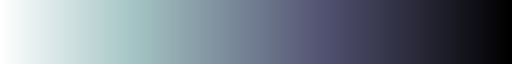

In [21]:
from sunpy.visualization import colormaps as cm

lc3_reg = cm.cmlist['soholasco3']
lc3_reg

lc3 = cm.cmlist['soholasco3'].reversed()
lc3

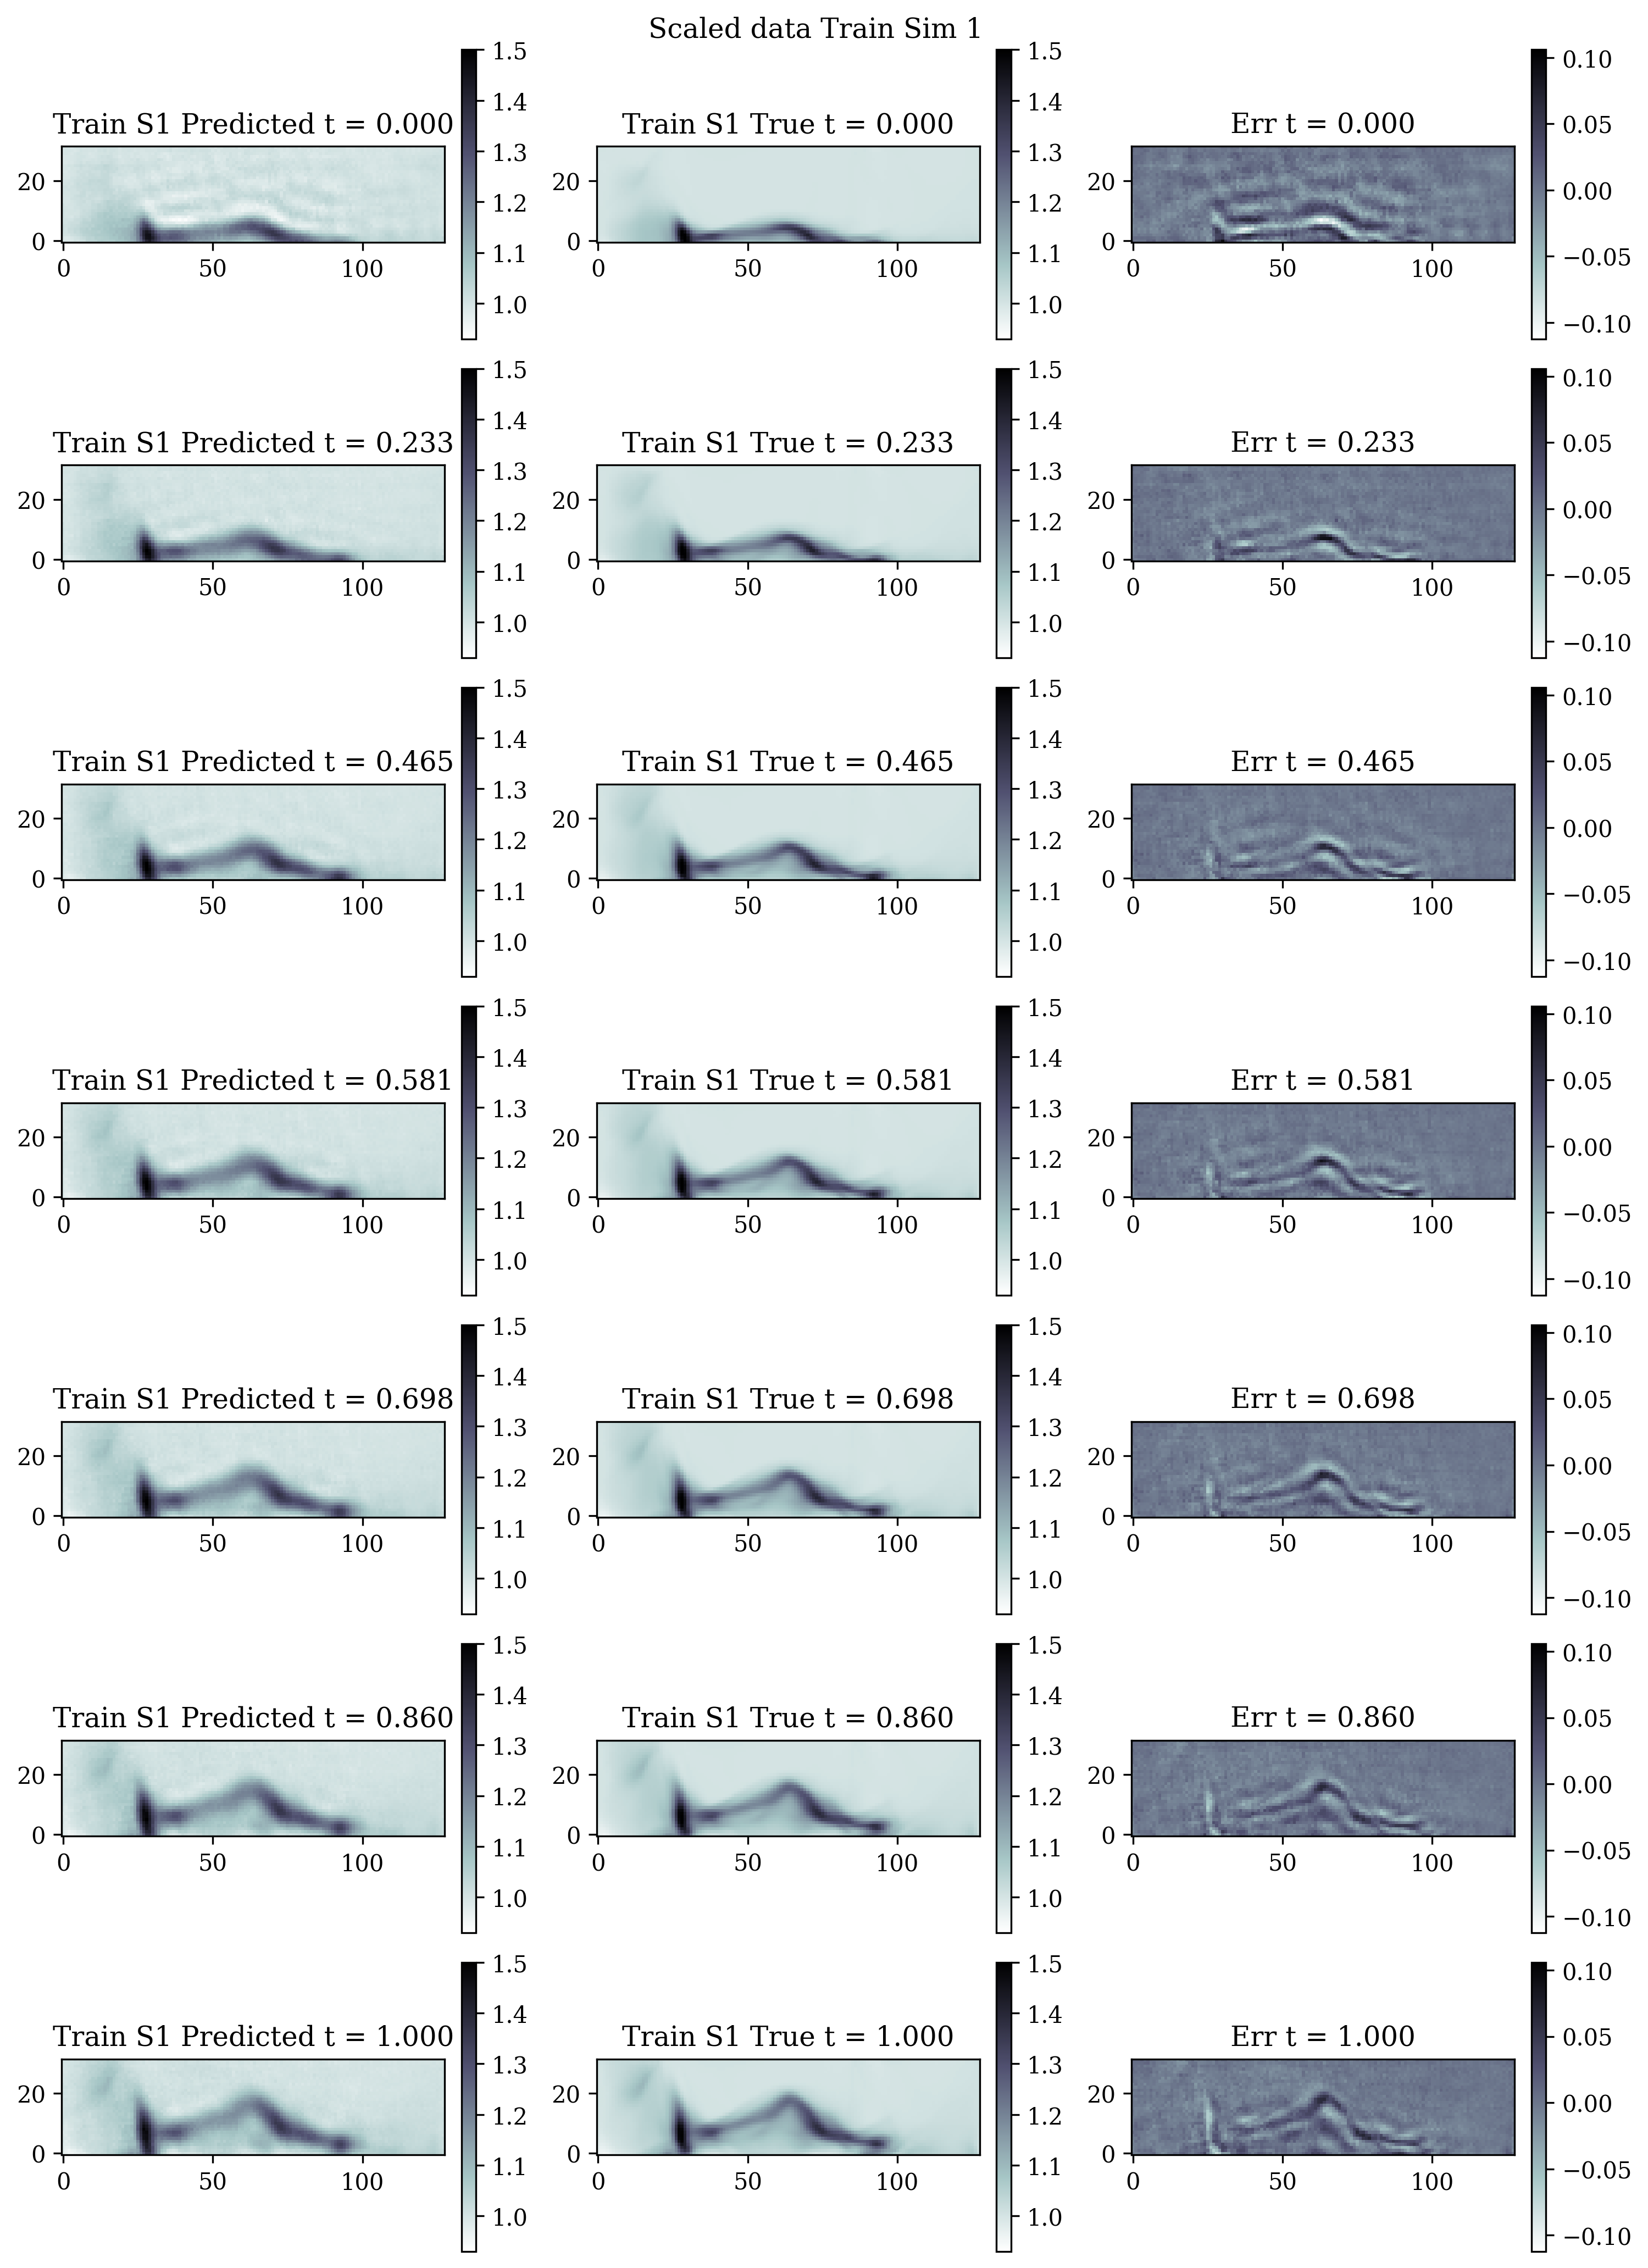

In [24]:
time_idx_to_plot = np.array([0, 10, 20, 25, 30, 37, 43])
sim_idx = 0

train_err_sim = train_target_rs[sim_idx, :, :, :] - train_pred_rs[sim_idx, :, :]


fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(10, 14))

for row in range(7):
    im = axs[row, 0].imshow(train_pred_rs[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=trainMin,
                           vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
    axs[row, 0].set_title("Train S1 Predicted t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
      

for row in range(7):
    im = axs[row, 1].imshow(train_target_rs[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=trainMin,
                           vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
    axs[row, 1].set_title("Train S1 True t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
    
    
for row in range(7):
    im = axs[row, 2].imshow(train_err_sim[time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                            vmin=train_err_sim.min(),
                            vmax=train_err_sim.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
    axs[row, 2].set_title("Err t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))

fig.suptitle("Scaled data Train Sim 1")
fig.tight_layout()

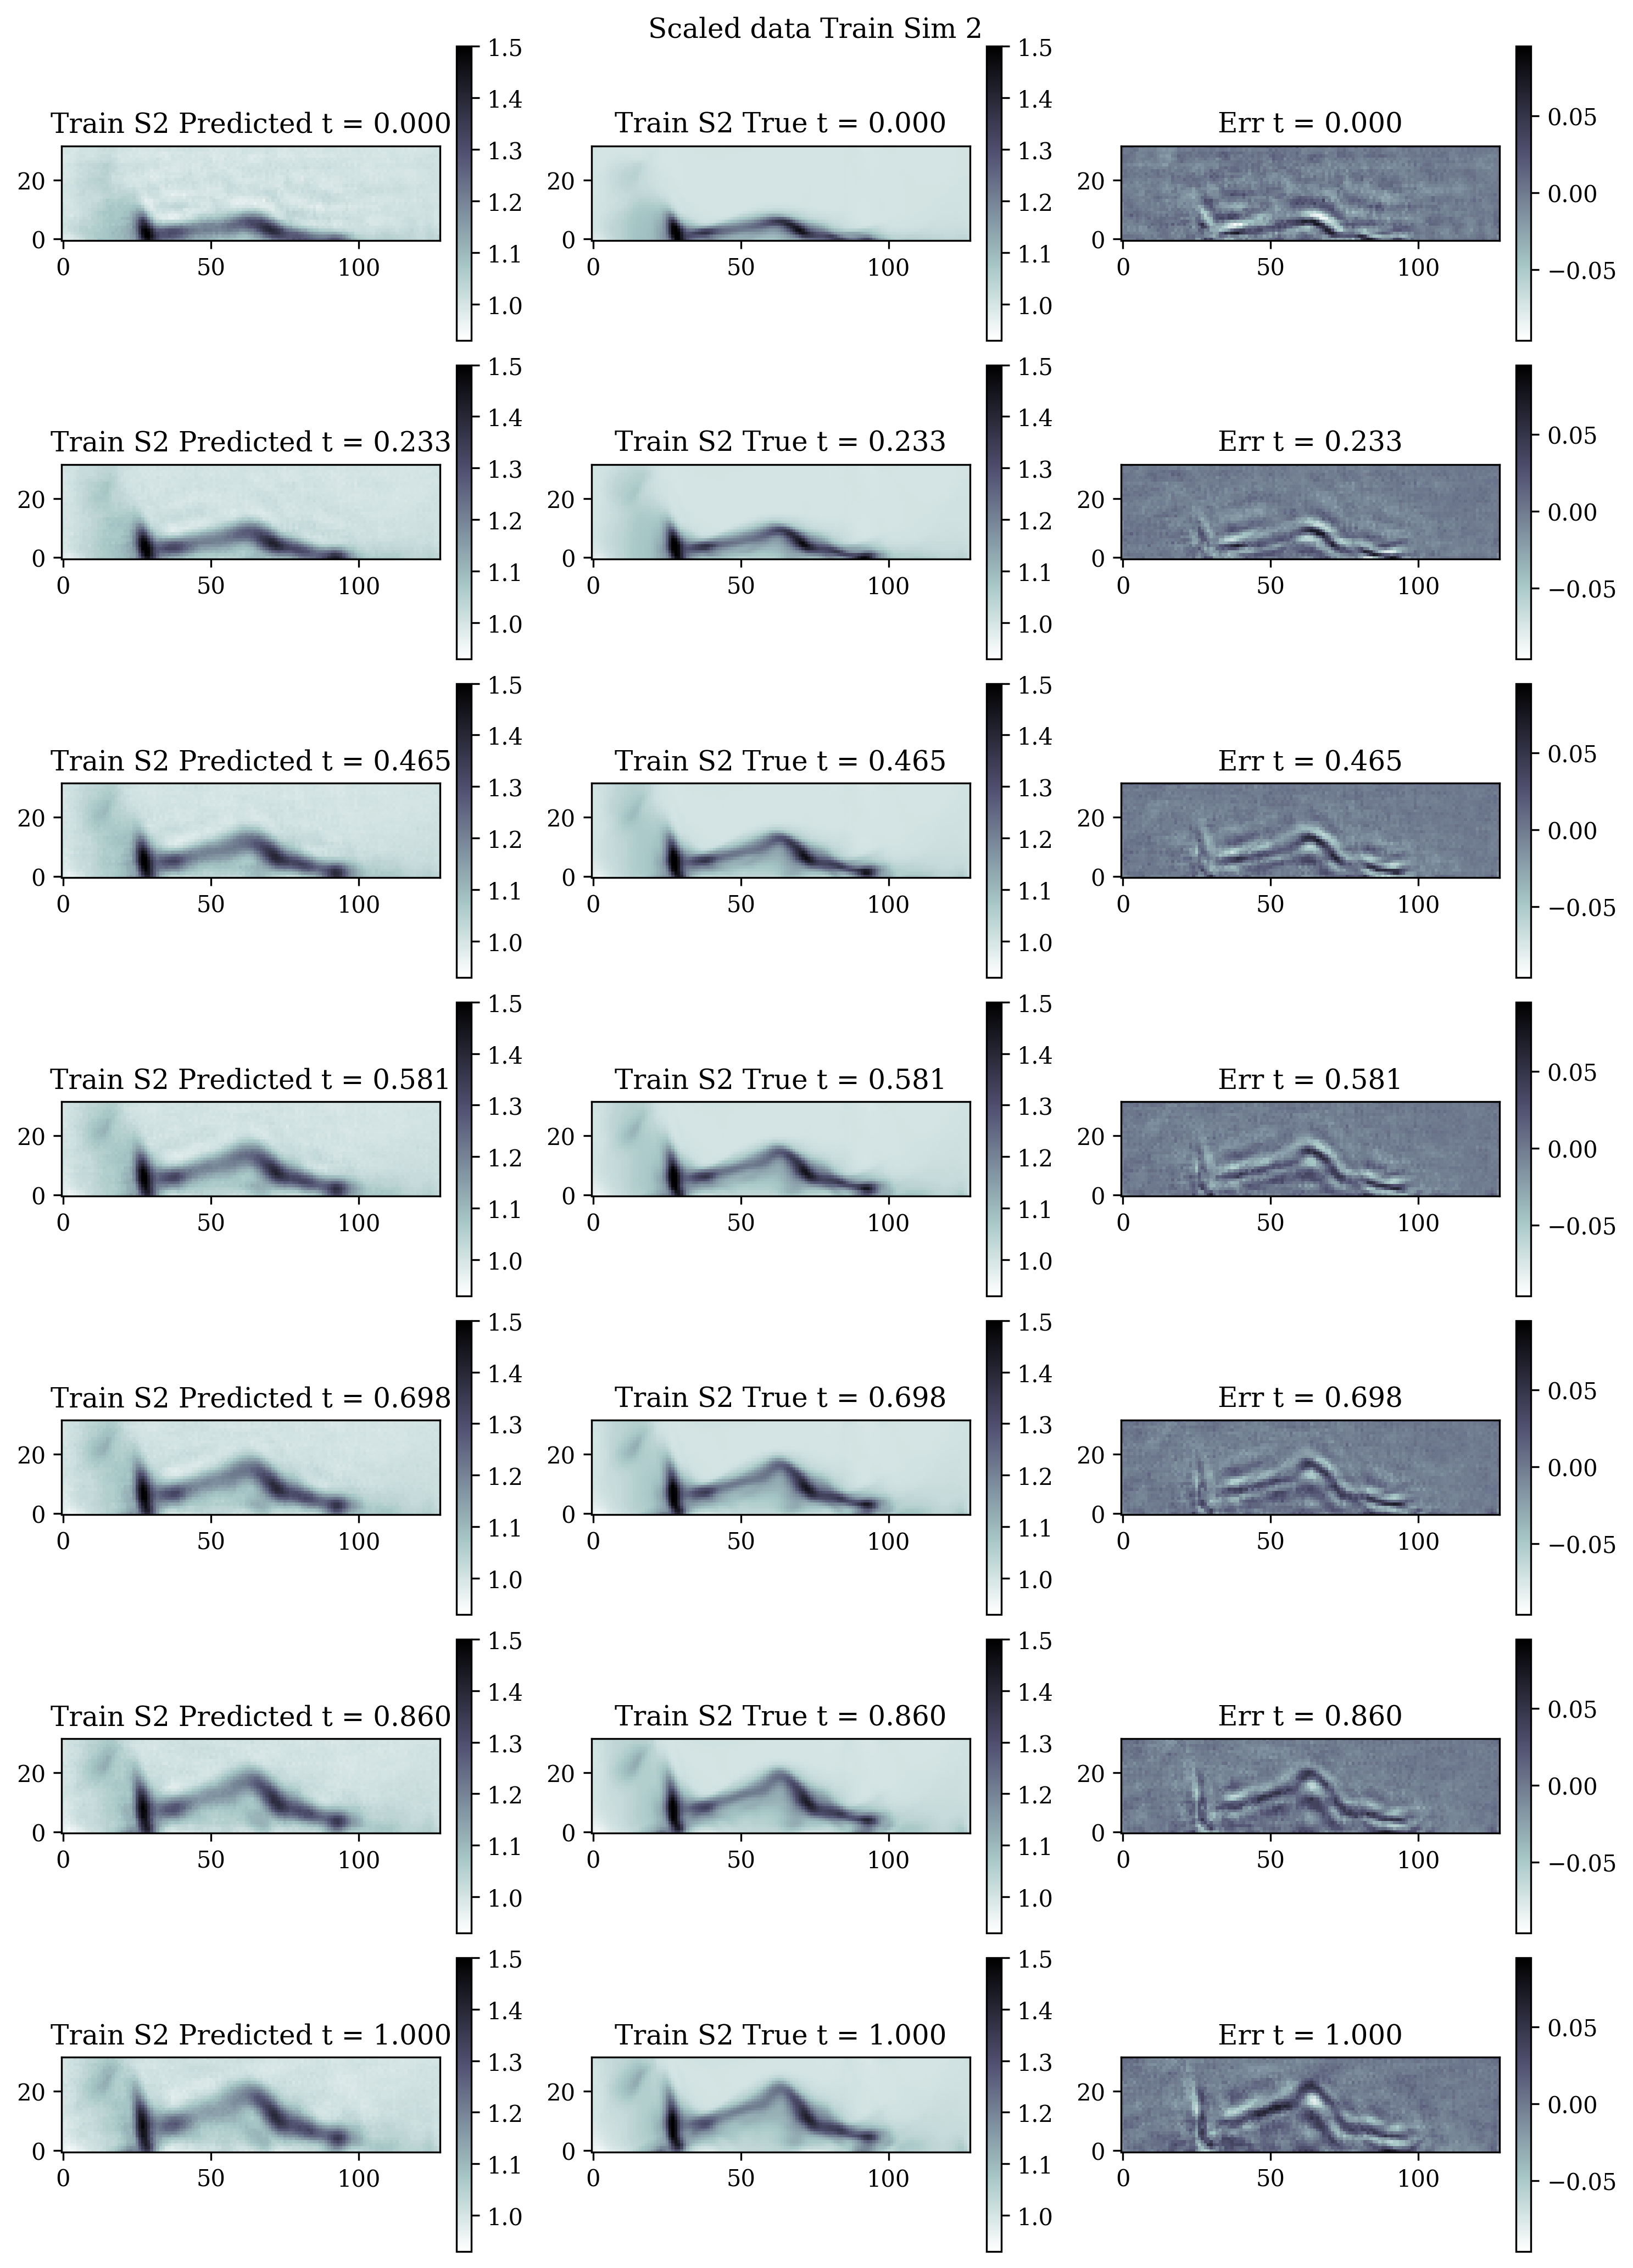

In [25]:
time_idx_to_plot = np.array([0, 10, 20, 25, 30, 37, 43])
sim_idx = 1

train_err_sim = train_target_rs[sim_idx, :, :, :] - train_pred_rs[sim_idx, :, :]


fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(10, 14))

for row in range(7):
    im = axs[row, 0].imshow(train_pred_rs[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=trainMin,
                           vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
    axs[row, 0].set_title("Train S2 Predicted t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
      

for row in range(7):
    im = axs[row, 1].imshow(train_target_rs[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=trainMin,
                           vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
    axs[row, 1].set_title("Train S2 True t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
    
    
for row in range(7):
    im = axs[row, 2].imshow(train_err_sim[time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                            vmin=train_err_sim.min(),
                            vmax=train_err_sim.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
    axs[row, 2].set_title("Err t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))

fig.suptitle("Scaled data Train Sim 2")
fig.tight_layout()

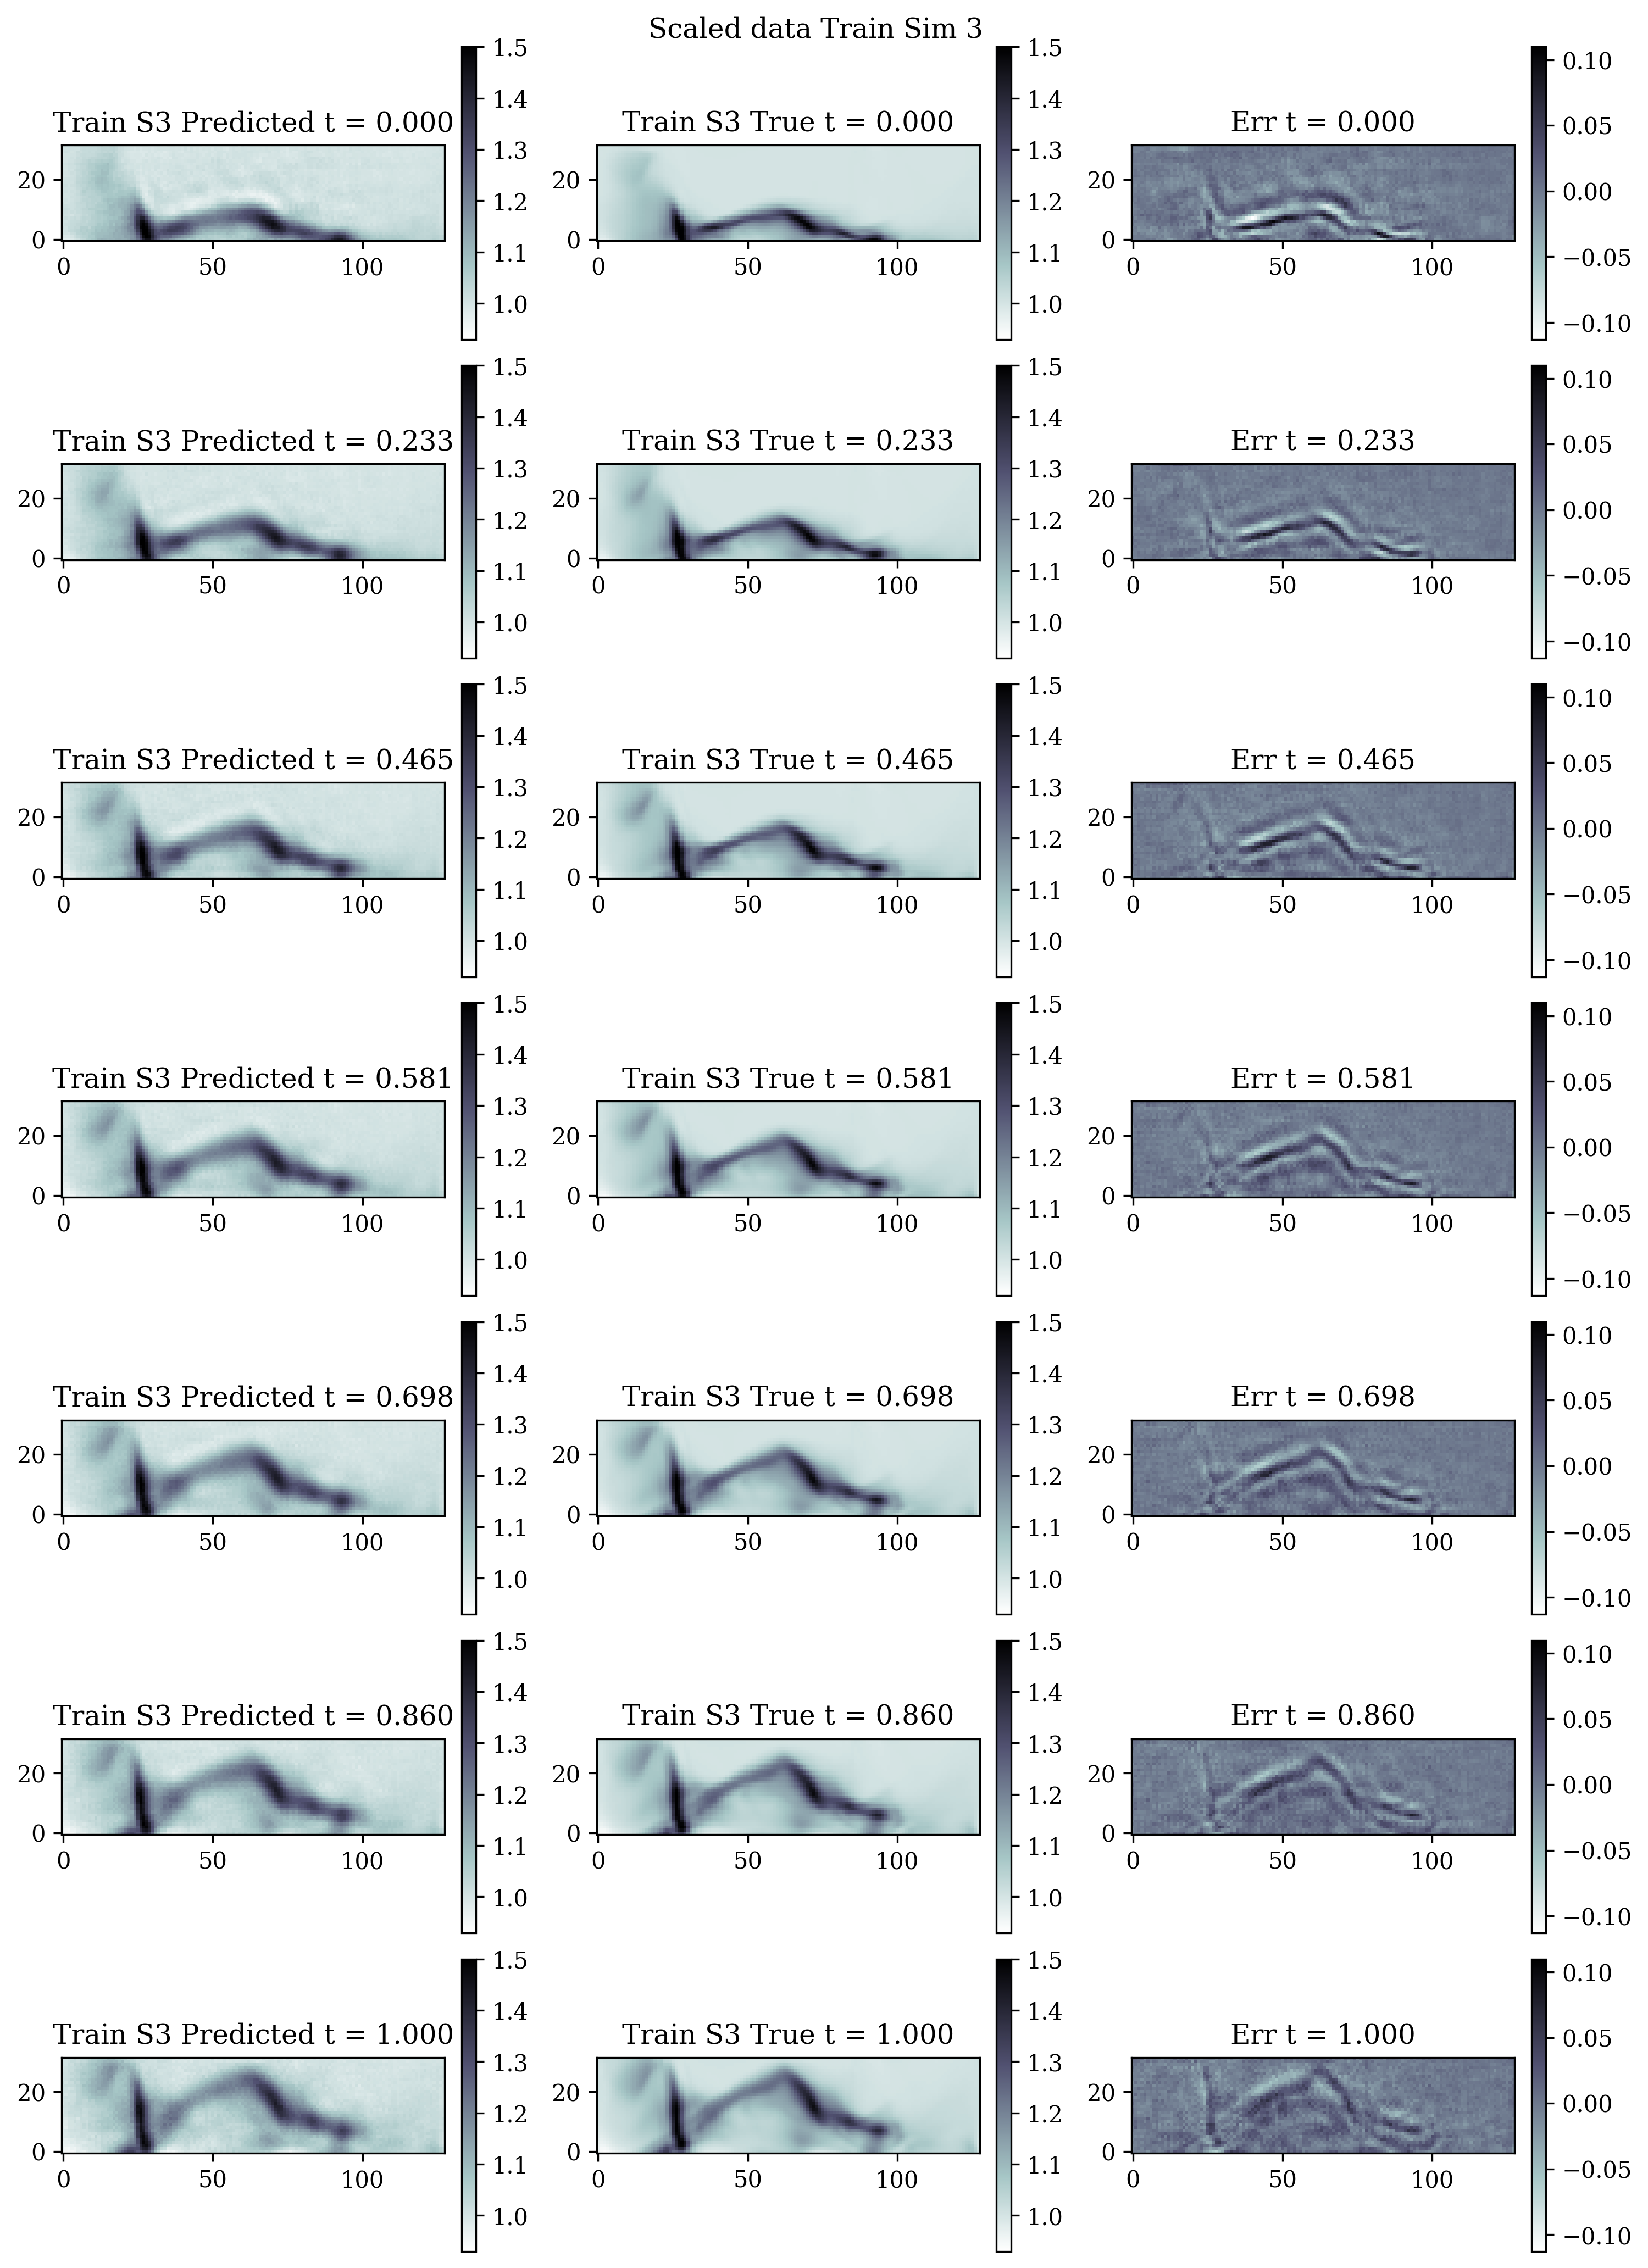

In [26]:
time_idx_to_plot = np.array([0, 10, 20, 25, 30, 37, 43])
sim_idx = 2

train_err_sim = train_target_rs[sim_idx, :, :, :] - train_pred_rs[sim_idx, :, :]


fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(10, 14))

for row in range(7):
    im = axs[row, 0].imshow(train_pred_rs[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=trainMin,
                           vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
    axs[row, 0].set_title("Train S3 Predicted t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
      

for row in range(7):
    im = axs[row, 1].imshow(train_target_rs[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=trainMin,
                           vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
    axs[row, 1].set_title("Train S3 True t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
    
    
for row in range(7):
    im = axs[row, 2].imshow(train_err_sim[time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                            vmin=train_err_sim.min(),
                            vmax=train_err_sim.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
    axs[row, 2].set_title("Err t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))

fig.suptitle("Scaled data Train Sim 3")
fig.tight_layout()

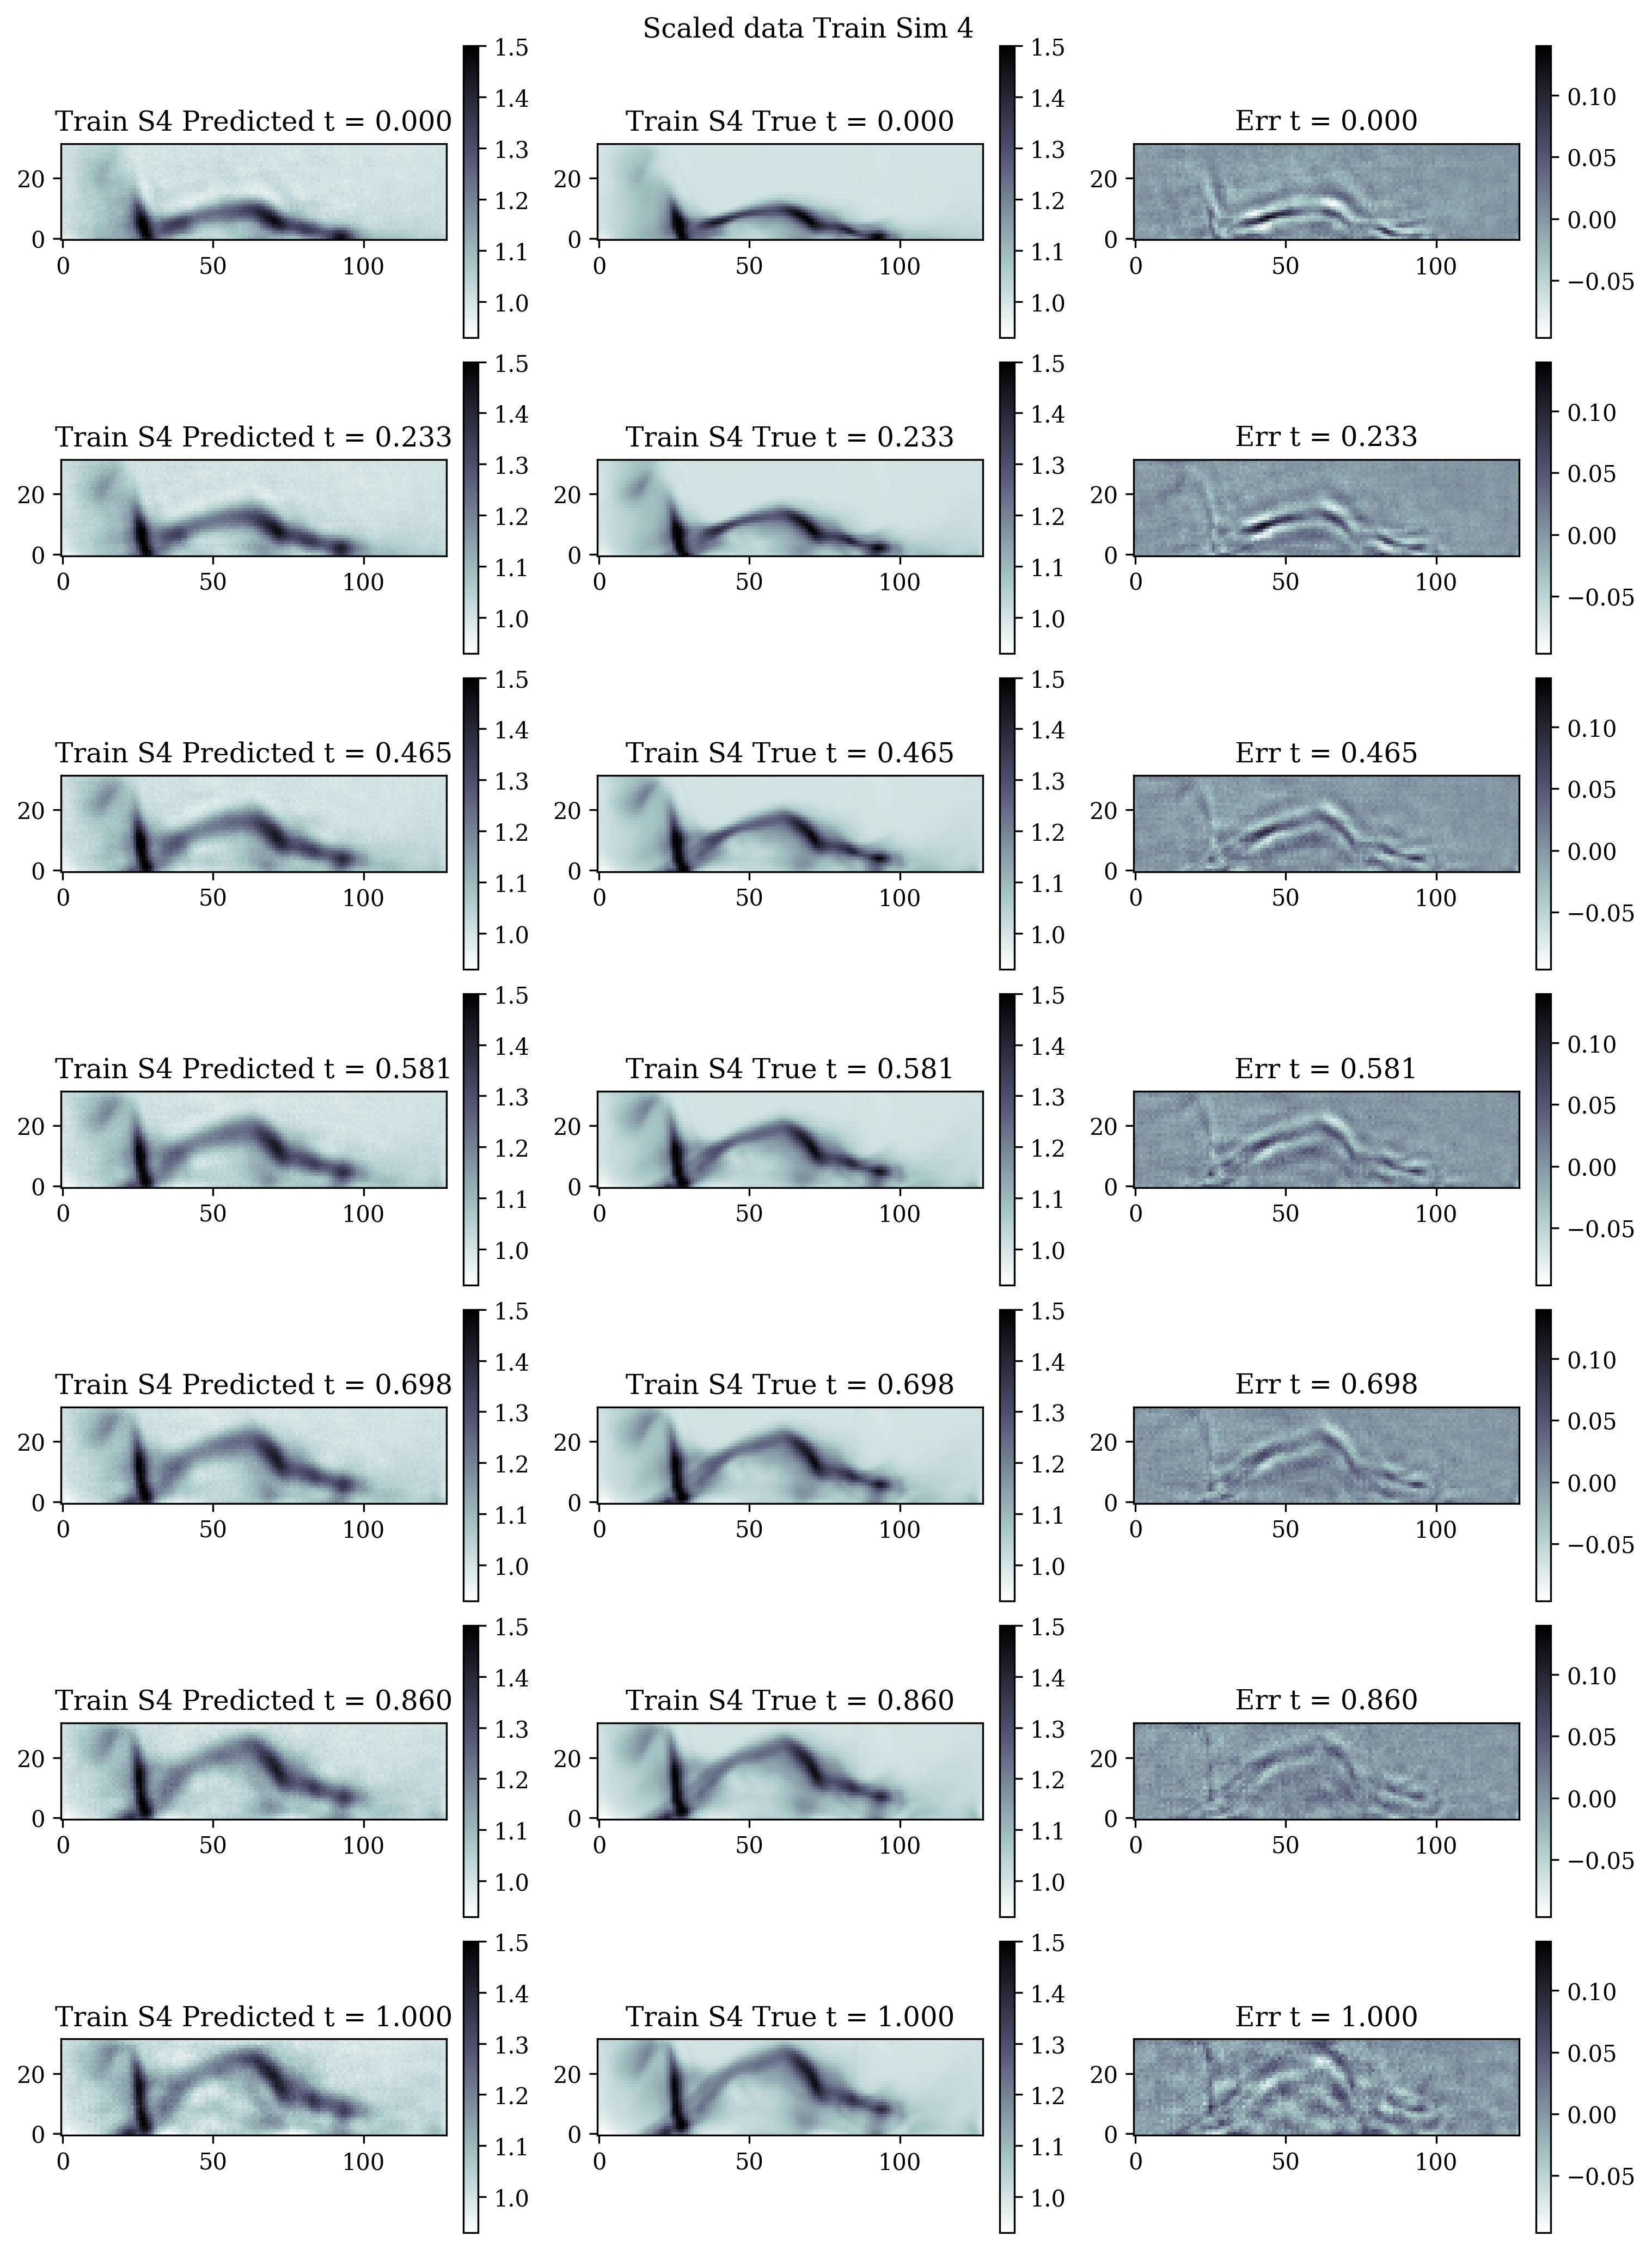

In [27]:
time_idx_to_plot = np.array([0, 10, 20, 25, 30, 37, 43])
sim_idx = 3

train_err_sim = train_target_rs[sim_idx, :, :, :] - train_pred_rs[sim_idx, :, :]


fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(10, 14))

for row in range(7):
    im = axs[row, 0].imshow(train_pred_rs[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=trainMin,
                           vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
    axs[row, 0].set_title("Train S4 Predicted t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
      

for row in range(7):
    im = axs[row, 1].imshow(train_target_rs[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=trainMin,
                           vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
    axs[row, 1].set_title("Train S4 True t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
    
    
for row in range(7):
    im = axs[row, 2].imshow(train_err_sim[time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                            vmin=train_err_sim.min(),
                            vmax=train_err_sim.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
    axs[row, 2].set_title("Err t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))

fig.suptitle("Scaled data Train Sim 4")
fig.tight_layout()

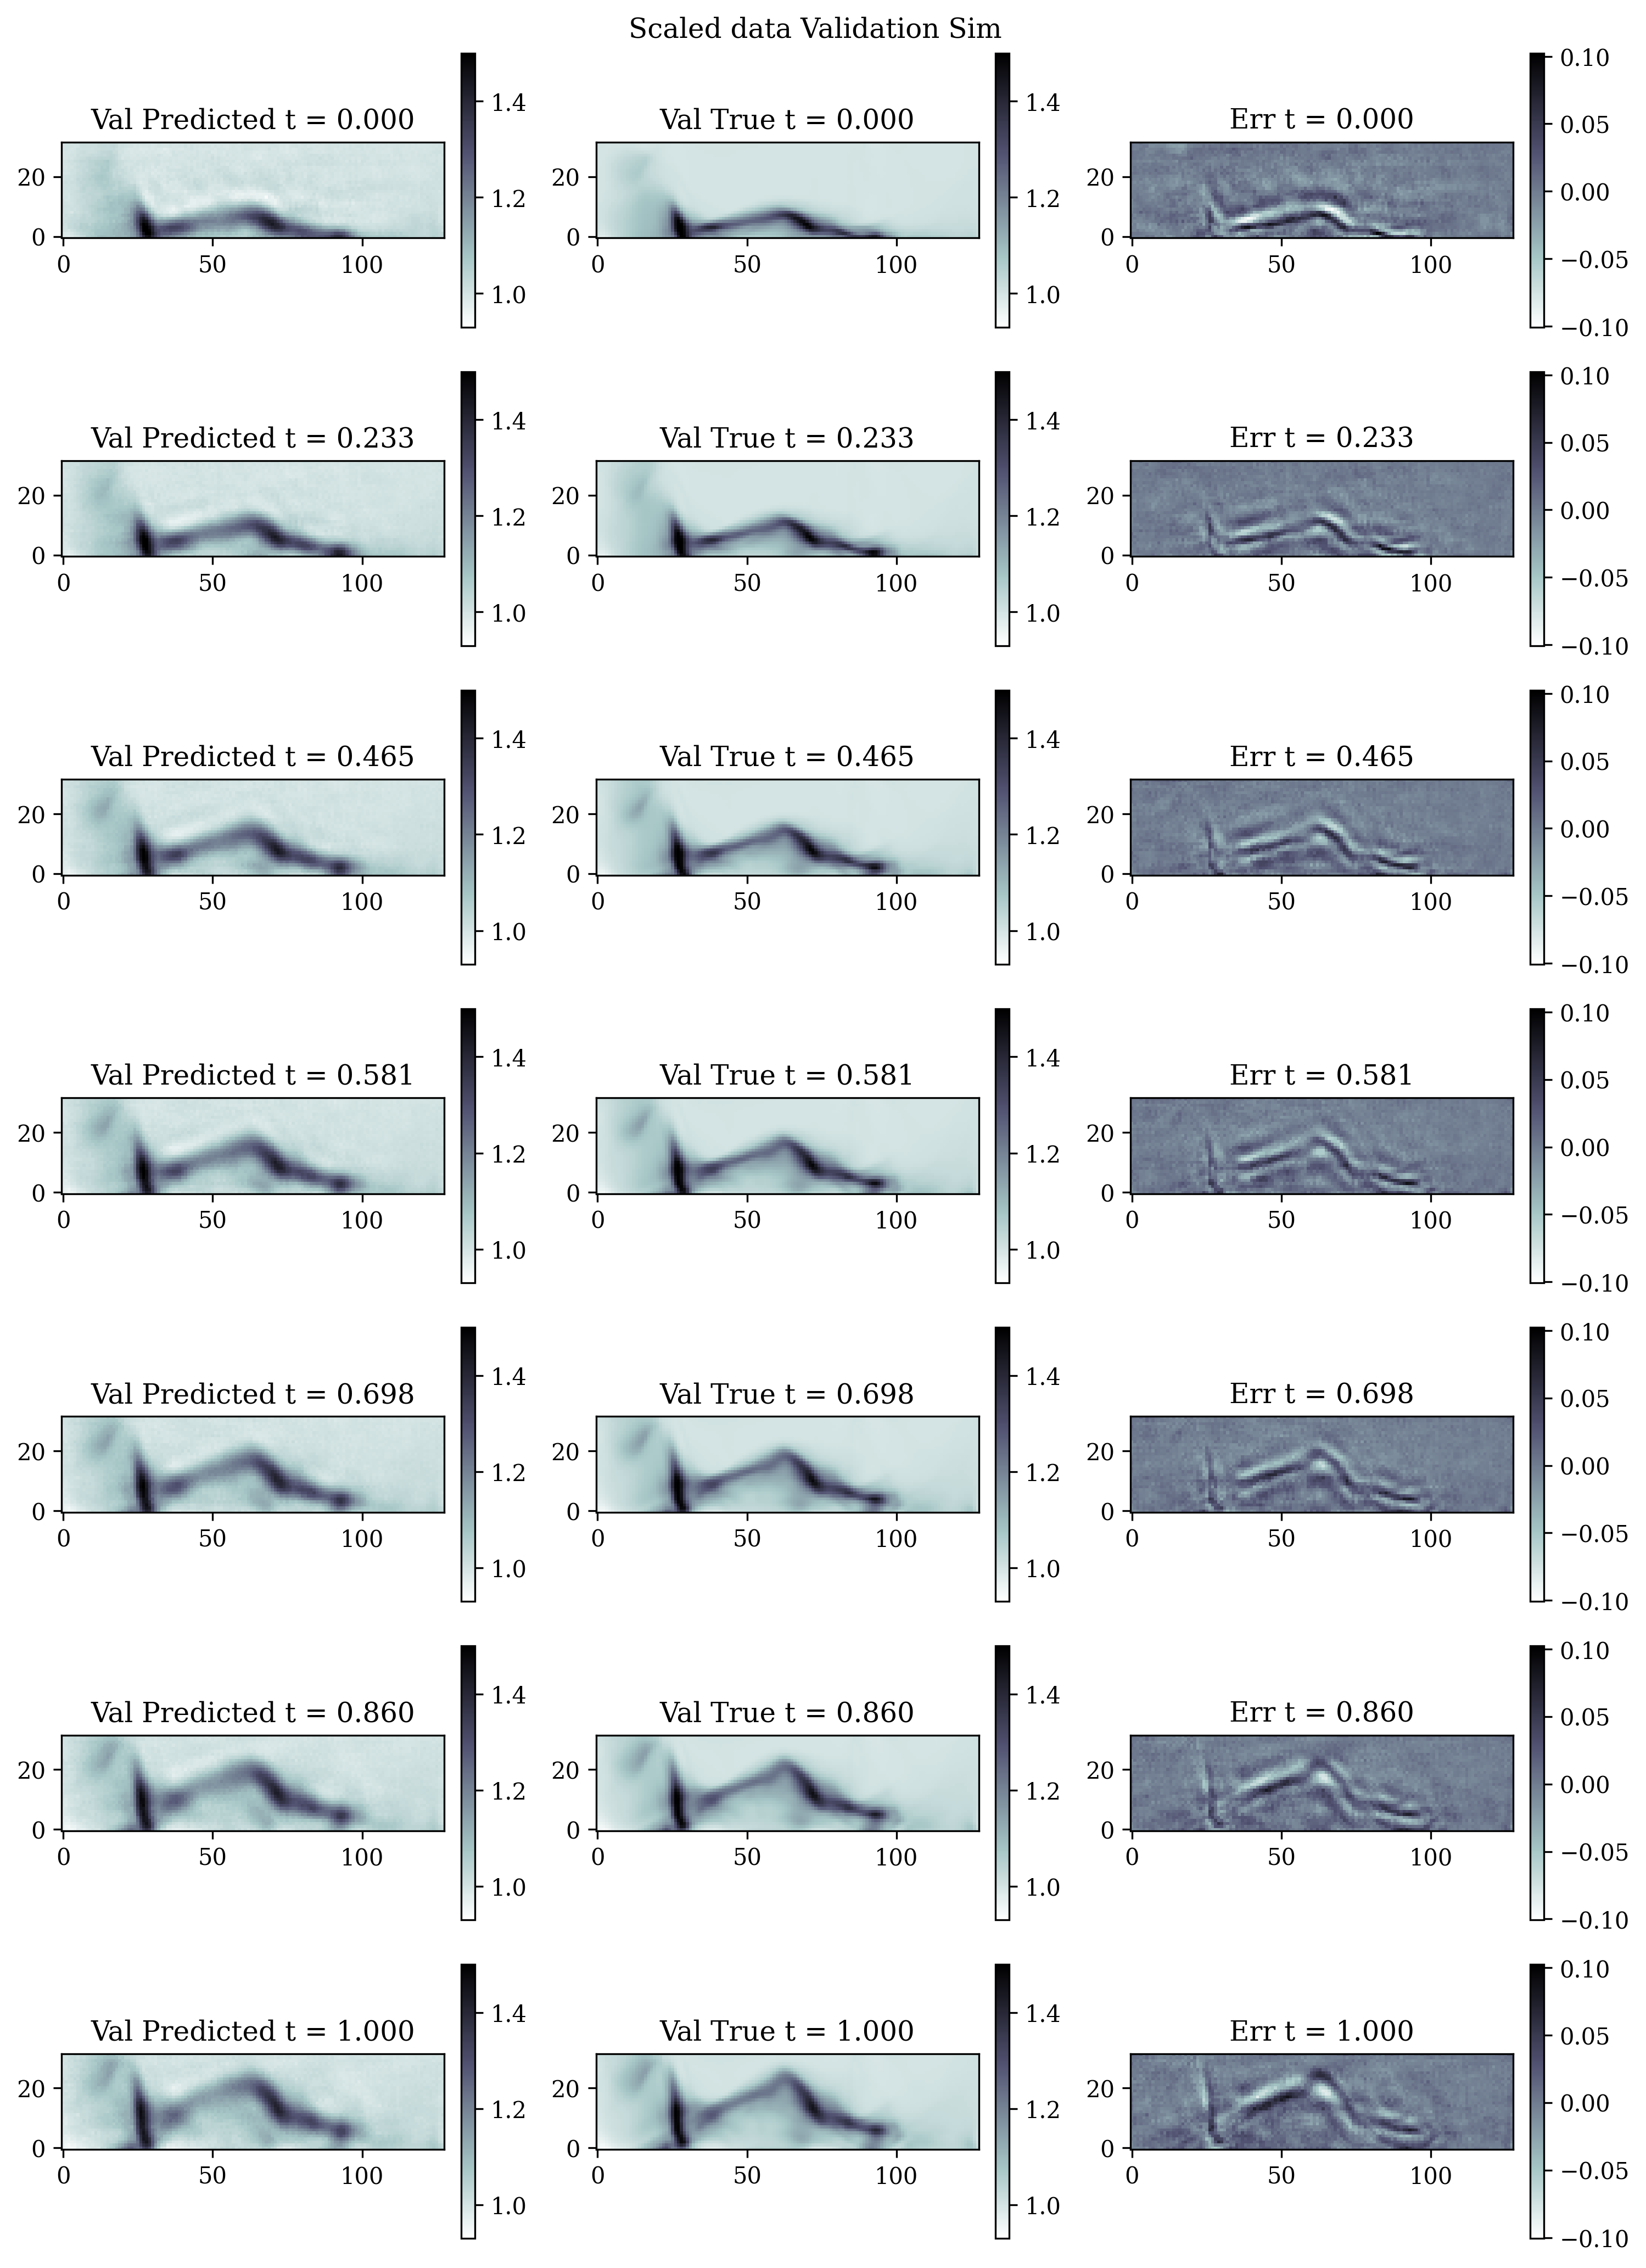

In [28]:
time_idx_to_plot = np.array([0, 10, 20, 25, 30, 37, 43])
sim_idx = 0
val_err_sim = val_target_rs[sim_idx, :, :, :] - val_pred_rs[sim_idx, :, :]


fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(10, 14))

for row in range(7):
    im = axs[row, 0].imshow(val_pred_rs[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=trainMin,
                           vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
    axs[row, 0].set_title("Val Predicted t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
      

for row in range(7):
    im = axs[row, 1].imshow(val_target_rs[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=trainMin,
                           vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
    axs[row, 1].set_title("Val True t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
    
    
for row in range(7):
    im = axs[row, 2].imshow(val_err_sim[time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                            vmin=val_err_sim.min(),
                            vmax=val_err_sim.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
    axs[row, 2].set_title("Err t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))

fig.suptitle("Scaled data Validation Sim")
fig.tight_layout()

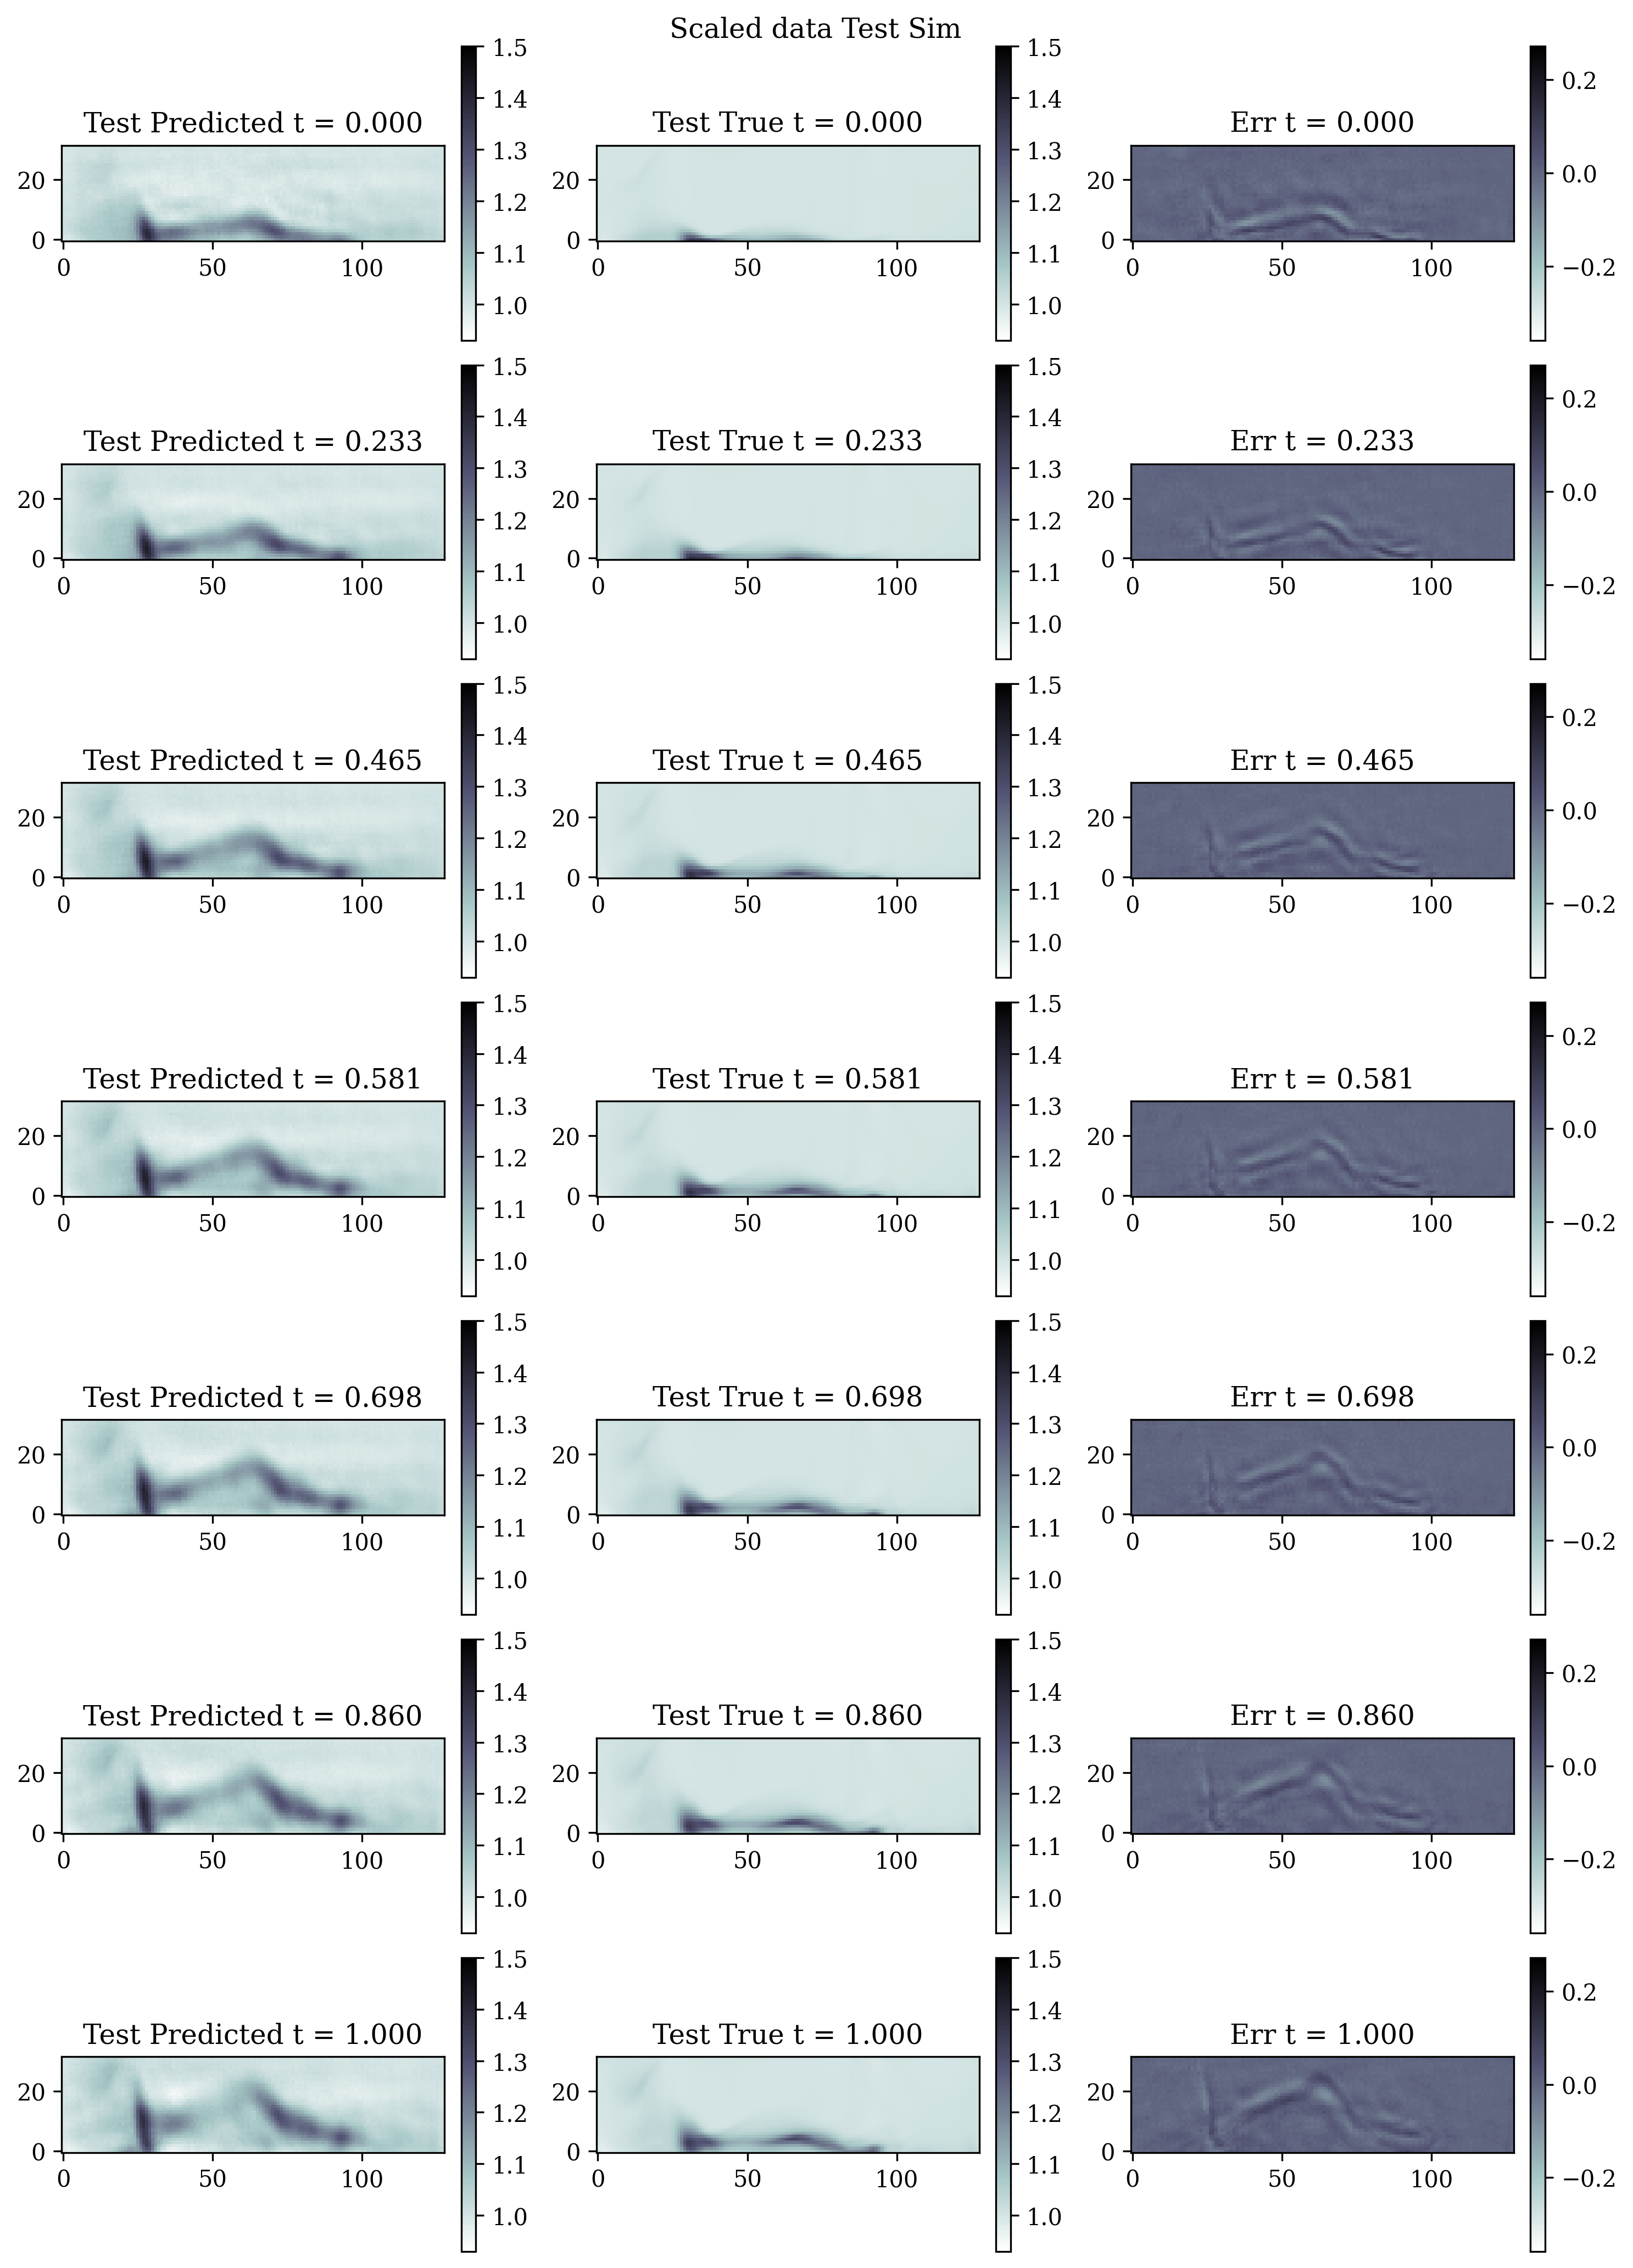

In [29]:
time_idx_to_plot = np.array([0, 10, 20, 25, 30, 37, 43])
sim_idx = 0
test_err_sim = test_target_rs[sim_idx, :, :, :] - test_pred_rs[sim_idx, :, :]


fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(10, 14))

for row in range(7):
    im = axs[row, 0].imshow(test_pred_rs[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=trainMin,
                           vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
    axs[row, 0].set_title("Test Predicted t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
      

for row in range(7):
    im = axs[row, 1].imshow(test_target_rs[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                           vmin=trainMin,
                           vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
    axs[row, 1].set_title("Test True t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))
    
    
for row in range(7):
    im = axs[row, 2].imshow(val_err_sim[time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3,
                            vmin=test_err_sim.min(),
                            vmax=test_err_sim.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
    axs[row, 2].set_title("Err t = {:.3f}".format(tpredict[time_idx_to_plot[row]]))

fig.suptitle("Scaled data Test Sim")
fig.tight_layout()

### Plotting test sim

In [ ]:
# # MODEL TESTING (ARCHITECTURE DIMS)
# data_obj = dut.parse_datasets(validation_file, sim_file, param_file, args, device)
# batch_dict = dut.get_next_batch(data_obj["val_dataloader"], device=device)

# y0 = batch_dict['observed_data']
# t0 = batch_dict['observed_tp']
# yt = batch_dict['data_to_predict']
# tt = batch_dict['tp_to_predict']

# input_dim = data_obj["input_dim"]
# print(input_dim)

# model = nut.PNODE_Conv(input_dim=4096, latent_dim=args["latents"], param_dim=2, 
#                        device=device,
#                       n_layers=args["node-layers"],
#                       n_units=args["units"]).to(device)

# init_state = y0[:, :, :input_dim].to(device)
# print(init_state.shape)
# nbatch, ntraj, nseq = init_state.shape
# print(nbatch, ntraj, nseq)
# init_state = init_state.reshape((ntraj*nbatch, 1, 32, 128))
# print(init_state.shape)

# print(model.encoder[0](init_state).shape)
# print(model.encoder[0:2](init_state).shape)
# print(model.encoder[0:4](init_state).shape)
# print(model.encoder[0:5](init_state).shape)
# print(model.encoder[0:7](init_state).shape)
# print(model.encoder[0:8](init_state).shape)
# print(model.encoder[0:10](init_state).shape)
# print(model.encoder[0:11](init_state).shape)
# print(model.encoder[0:13](init_state).shape)
# print(model.encoder[0:15](init_state).shape)
# print(model.encoder[0:16](init_state).shape)
# print(model.encoder[0:18](init_state).shape)
# print(model.encoder(init_state).shape)
# print(model.encoder(init_state).reshape((nbatch, ntraj, args["latents"])).shape)

# init_latent = model.encoder(init_state).reshape((nbatch, ntraj, args["latents"]))
# init_latent = torch.cat((init_latent, y0[:, :, input_dim:]), -1)
# print(init_latent.shape)
# latent_states = odeint(model.pnode, init_latent, tt)
# print(latent_states.shape)

# ls_init = latent_states[:, :, :, :args["latents"]]
# print(ls_init.shape)

# ntraj2, nbatch2, nseq2, _ = ls_init.shape
# print(ntraj2, nbatch2, nseq2)

# latent_mlp = model.decoder_mlp(ls_init)
# print(latent_mlp.shape)

# decoder_features = latent_mlp.reshape((-1, 64, 1, 4))
# print(decoder_features.shape)

# print(model.decoder_conv[0](decoder_features).shape)
# print(model.decoder_conv[0:3](decoder_features).shape)
# print(model.decoder_conv[0:5](decoder_features).shape)
# print(model.decoder_conv[0:8](decoder_features).shape)
# print(model.decoder_conv[0:10](decoder_features).shape)

# print(model.decoder_conv[0:10](decoder_features).reshape(ntraj2, nbatch2, nseq2, 4096).shape)

# print(model(tt, y0).shape)

# print(model)